<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
# import necessary packages
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import describe,skew

In [2]:
#!pip install missingno

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [3]:
# Load the data
house = pd.read_csv('./housing.csv')

In [4]:
# missing values
house.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive

In [5]:
#max missing values
house.isnull().sum().max()

1453

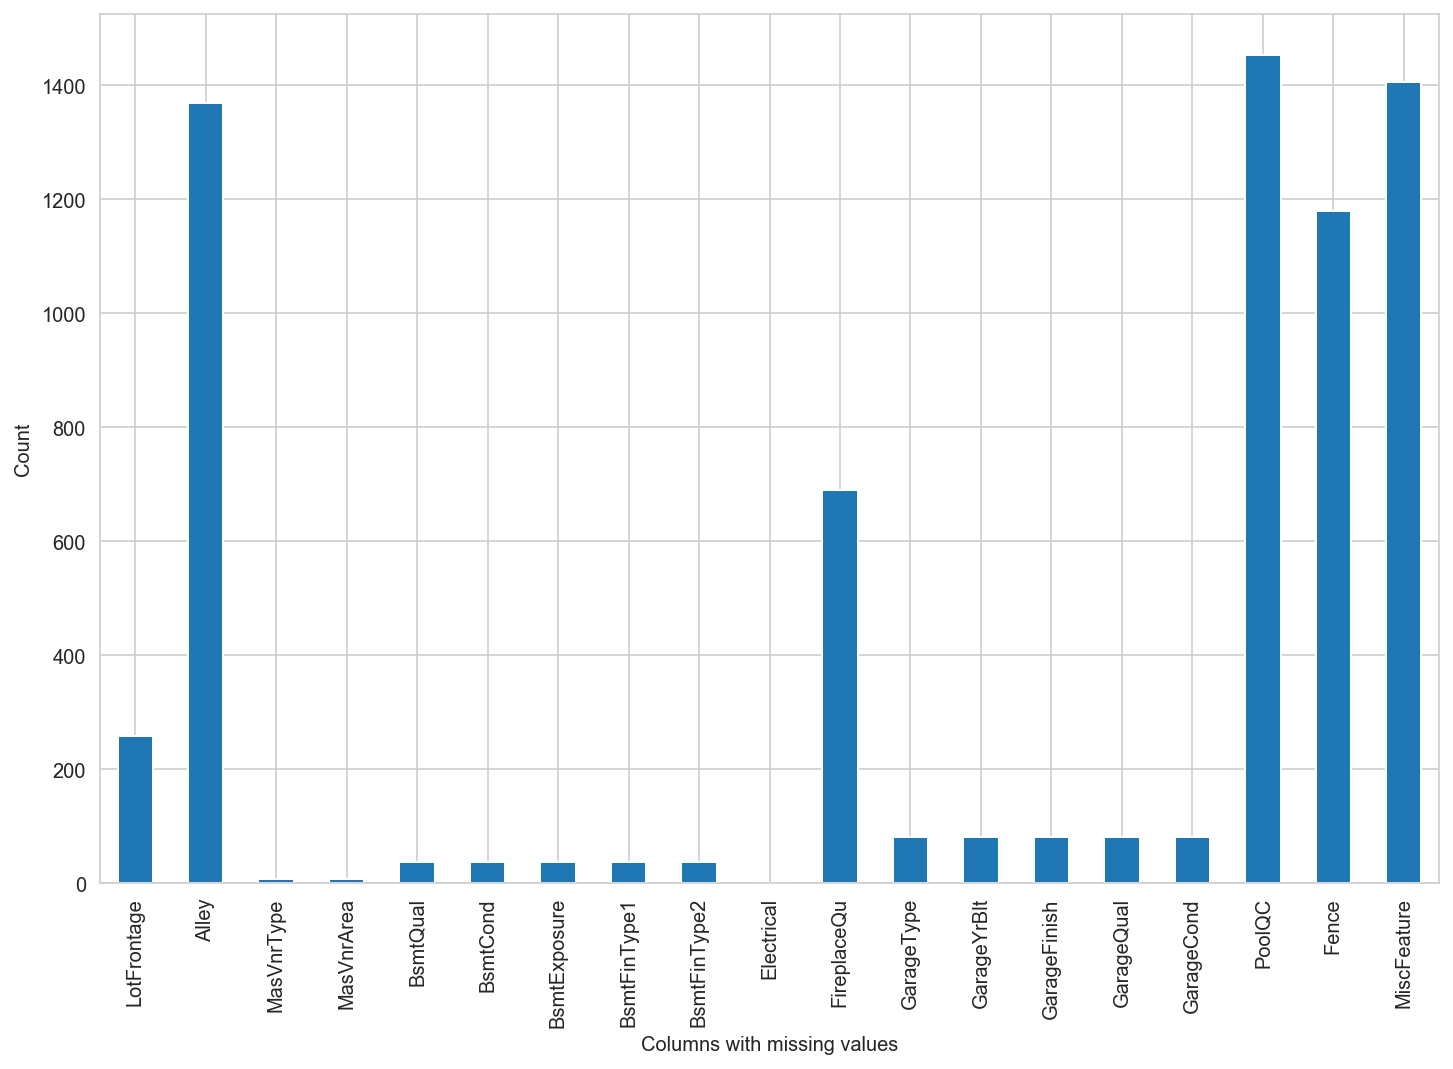

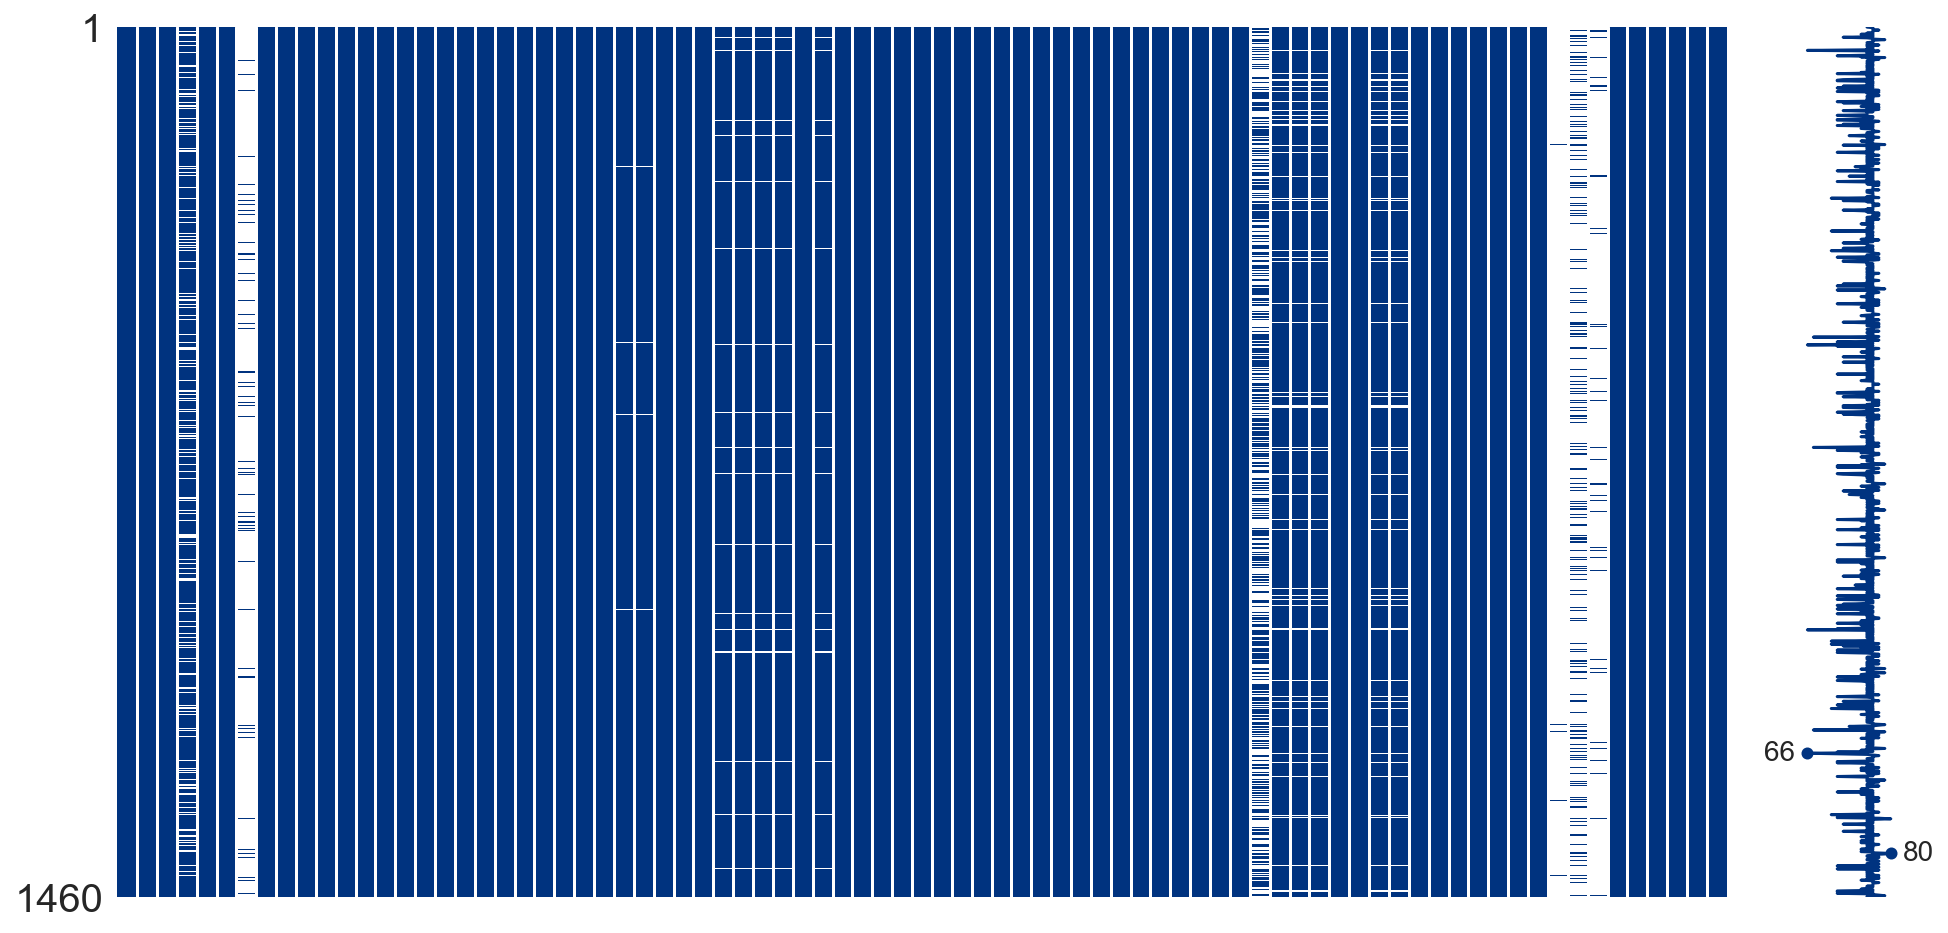

In [6]:
#Plot missing values 
def plot_missing(df):
    # Find columns having missing values and count
    missing = house.isnull().sum()
    missing = missing[missing > 0]
    #missing.sort_values(inplace=True)
    
    # Plot missing values by count 
    missing.plot.bar(figsize=(12,8))
    plt.xlabel('Columns with missing values')
    plt.ylabel('Count')
    
    # search for missing data
    import missingno as msno
    msno.matrix(df=df, figsize=(16,8), color=(0,0.2,0.5))
    
plot_missing(house)

In [7]:
#number of rows and columns
house.shape

(1460, 81)

In [8]:
# different features
house.columns


Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [9]:
#Now, I will take only fixed characteristics
house_fixed = house[['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'Foundation','BsmtExposure', 'BsmtFinType1', 
       'BsmtFinSF1','BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF','EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC','Fence', 'MiscFeature', 'MiscVal', 'MoSold', 
       'YrSold', 'SaleType', 'SaleCondition', 'SalePrice']]

renovateable_features = house[['RoofStyle','RoofMatl','Exterior1st','ExterCond',
              'BsmtCond','HeatingQC','CentralAir','Electrical',
              'GarageFinish','GarageCond','PavedDrive',
              'ExterQual','BsmtQual','GarageQual','KitchenQual',
              'FireplaceQu']]
Data = house_fixed.append(renovateable_features, ignore_index = True)

In [10]:
# A: first 5 rows of data
Data.head()

1stFlrSF  2ndFlrSF  3SsnPorch Alley  BedroomAbvGr BldgType BsmtCond  \
0     856.0     854.0        0.0   NaN           3.0     1Fam      NaN   
1    1262.0       0.0        0.0   NaN           3.0     1Fam      NaN   
2     920.0     866.0        0.0   NaN           3.0     1Fam      NaN   
3     961.0     756.0        0.0   NaN           3.0     1Fam      NaN   
4    1145.0    1053.0        0.0   NaN           4.0     1Fam      NaN   

  BsmtExposure  BsmtFinSF1  BsmtFinSF2  ... SaleType ScreenPorch  Street  \
0           No       706.0         0.0  ...       WD         0.0    Pave   
1           Gd       978.0         0.0  ...       WD         0.0    Pave   
2           Mn       486.0         0.0  ...       WD         0.0    Pave   
3           No       216.0         0.0  ...       WD         0.0    Pave   
4           Av       655.0         0.0  ...       WD         0.0    Pave   

   TotRmsAbvGrd TotalBsmtSF  Utilities WoodDeckSF YearBuilt YearRemodAdd  \
0           8.0       856.0     AllPub        0.0    2003.0       2003.0   
1           6.0      1262.0     AllPub      298.0    1976.0       1976.0   
2           6.0       920.0     AllPub        0.0    2001.0       2002.0   
3           7.0       756.0     AllPub        0.0    1915.0       1970.0   
4           9.0      1145.0     AllPub      192.0    2000.0       2000.0   

   YrSold  
0  2008.0  
1  2007.0  
2  2008.0  
3  2006.0  
4  2008.0  

[5 rows x 81 columns]

In [11]:
Data.shape

(2920, 81)

In [12]:
# further information about fixed characterisitcts data
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2920 entries, 0 to 2919
Data columns (total 81 columns):
1stFlrSF         1460 non-null float64
2ndFlrSF         1460 non-null float64
3SsnPorch        1460 non-null float64
Alley            91 non-null object
BedroomAbvGr     1460 non-null float64
BldgType         1460 non-null object
BsmtCond         1423 non-null object
BsmtExposure     1422 non-null object
BsmtFinSF1       1460 non-null float64
BsmtFinSF2       1460 non-null float64
BsmtFinType1     1423 non-null object
BsmtFinType2     1422 non-null object
BsmtFullBath     1460 non-null float64
BsmtHalfBath     1460 non-null float64
BsmtQual         1423 non-null object
BsmtUnfSF        1460 non-null float64
CentralAir       1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
Electrical       1459 non-null object
EnclosedPorch    1460 non-null float64
ExterCond        1460 non-null object
ExterQual        1460 non-null object
Exterior1st

In [13]:
Data_corr = Data.corr()
Data_corr

1stFlrSF  2ndFlrSF  3SsnPorch  BedroomAbvGr  BsmtFinSF1  \
1stFlrSF       1.000000 -0.202646   0.056104      0.127401    0.445863   
2ndFlrSF      -0.202646  1.000000  -0.024358      0.502901   -0.137079   
3SsnPorch      0.056104 -0.024358   1.000000     -0.024478    0.026451   
BedroomAbvGr   0.127401  0.502901  -0.024478      1.000000   -0.107355   
BsmtFinSF1     0.445863 -0.137079   0.026451     -0.107355    1.000000   
BsmtFinSF2     0.097117 -0.099260  -0.029993     -0.015728   -0.050117   
BsmtFullBath   0.244671 -0.169494  -0.000106     -0.150673    0.649212   
BsmtHalfBath   0.001956 -0.023855   0.035114      0.046519    0.067418   
BsmtUnfSF      0.317987  0.004469   0.020764      0.166643   -0.495251   
EnclosedPorch -0.065292  0.061989  -0.037305      0.041570   -0.102303   
Fireplaces     0.410531  0.194561   0.011257      0.107570    0.260011   
FullBath       0.380637  0.421378   0.035353      0.363252    0.058543   
GarageArea     0.489782  0.138347   0.035087      0.065253    0.296970   
GarageCars     0.439317  0.183926   0.035765      0.086106    0.224054   
GarageYrBlt    0.233449  0.070832   0.023544     -0.064518    0.153484   
GrLivArea      0.566024  0.687501   0.020643      0.521270    0.208171   
HalfBath      -0.119916  0.609707  -0.004972      0.226651    0.004262   
Id             0.010496  0.005590  -0.046635      0.037719   -0.005024   
KitchenAbvGr   0.068101  0.059306  -0.024600      0.198597   -0.081007   
LotArea        0.299475  0.050986   0.020423      0.119690    0.214103   
LotFrontage    0.457181  0.080177   0.070029      0.263170    0.233633   
LowQualFinSF  -0.014241  0.063353  -0.004296      0.105607   -0.064503   
MSSubClass    -0.251758  0.307886  -0.043825     -0.023438   -0.069836   
MasVnrArea     0.344501  0.174561   0.018796      0.102821    0.264736   
MiscVal       -0.021096  0.016197   0.000354      0.007767    0.003571   
MoSold         0.031372  0.035164   0.029474      0.046544   -0.015727   
OpenPorchSF    0.211671  0.208026  -0.005842      0.093810    0.111761   
OverallCond   -0.144203  0.028942   0.025504      0.012980   -0.046231   
OverallQual    0.476224  0.295493   0.030371      0.101676    0.239666   
PoolArea       0.131525  0.081487  -0.007992      0.070703    0.140491   
SalePrice      0.605852  0.319334   0.044584      0.168213    0.386420   
ScreenPorch    0.088758  0.040606  -0.031436      0.044300    0.062021   
TotRmsAbvGrd   0.409516  0.616423  -0.006683      0.676620    0.044316   
TotalBsmtSF    0.819530 -0.174512   0.037384      0.050450    0.522396   
WoodDeckSF     0.235459  0.092165  -0.032771      0.046854    0.204306   
YearBuilt      0.281986  0.010308   0.031355     -0.070651    0.249503   
YearRemodAdd   0.240379  0.140024   0.045286     -0.040581    0.128451   
YrSold        -0.013604 -0.028700   0.018645     -0.036014    0.014359   

               BsmtFinSF2  BsmtFullBath  BsmtHalfBath  BsmtUnfSF  \
1stFlrSF         0.097117      0.244671      0.001956   0.317987   
2ndFlrSF        -0.099260     -0.169494     -0.023855   0.004469   
3SsnPorch       -0.029993     -0.000106      0.035114   0.020764   
BedroomAbvGr    -0.015728     -0.150673      0.046519   0.166643   
BsmtFinSF1      -0.050117      0.649212      0.067418  -0.495251   
BsmtFinSF2       1.000000      0.158678      0.070948  -0.209294   
BsmtFullBath     0.158678      1.000000     -0.147871  -0.422900   
BsmtHalfBath     0.070948     -0.147871      1.000000  -0.095804   
BsmtUnfSF       -0.209294     -0.422900     -0.095804   1.000000   
EnclosedPorch    0.036543     -0.049911     -0.008555  -0.002538   
Fireplaces       0.046921      0.137928      0.028976   0.051575   
FullBath        -0.076444     -0.064512     -0.054536   0.288886   
GarageArea      -0.018227      0.179189     -0.024536   0.183303   
GarageCars      -0.038264      0.131881     -0.020891   0.214175   
GarageYrBlt     -0.088011      0.124553     -0.077464   0.190708   
GrLivArea       -0.009640      0.034836 

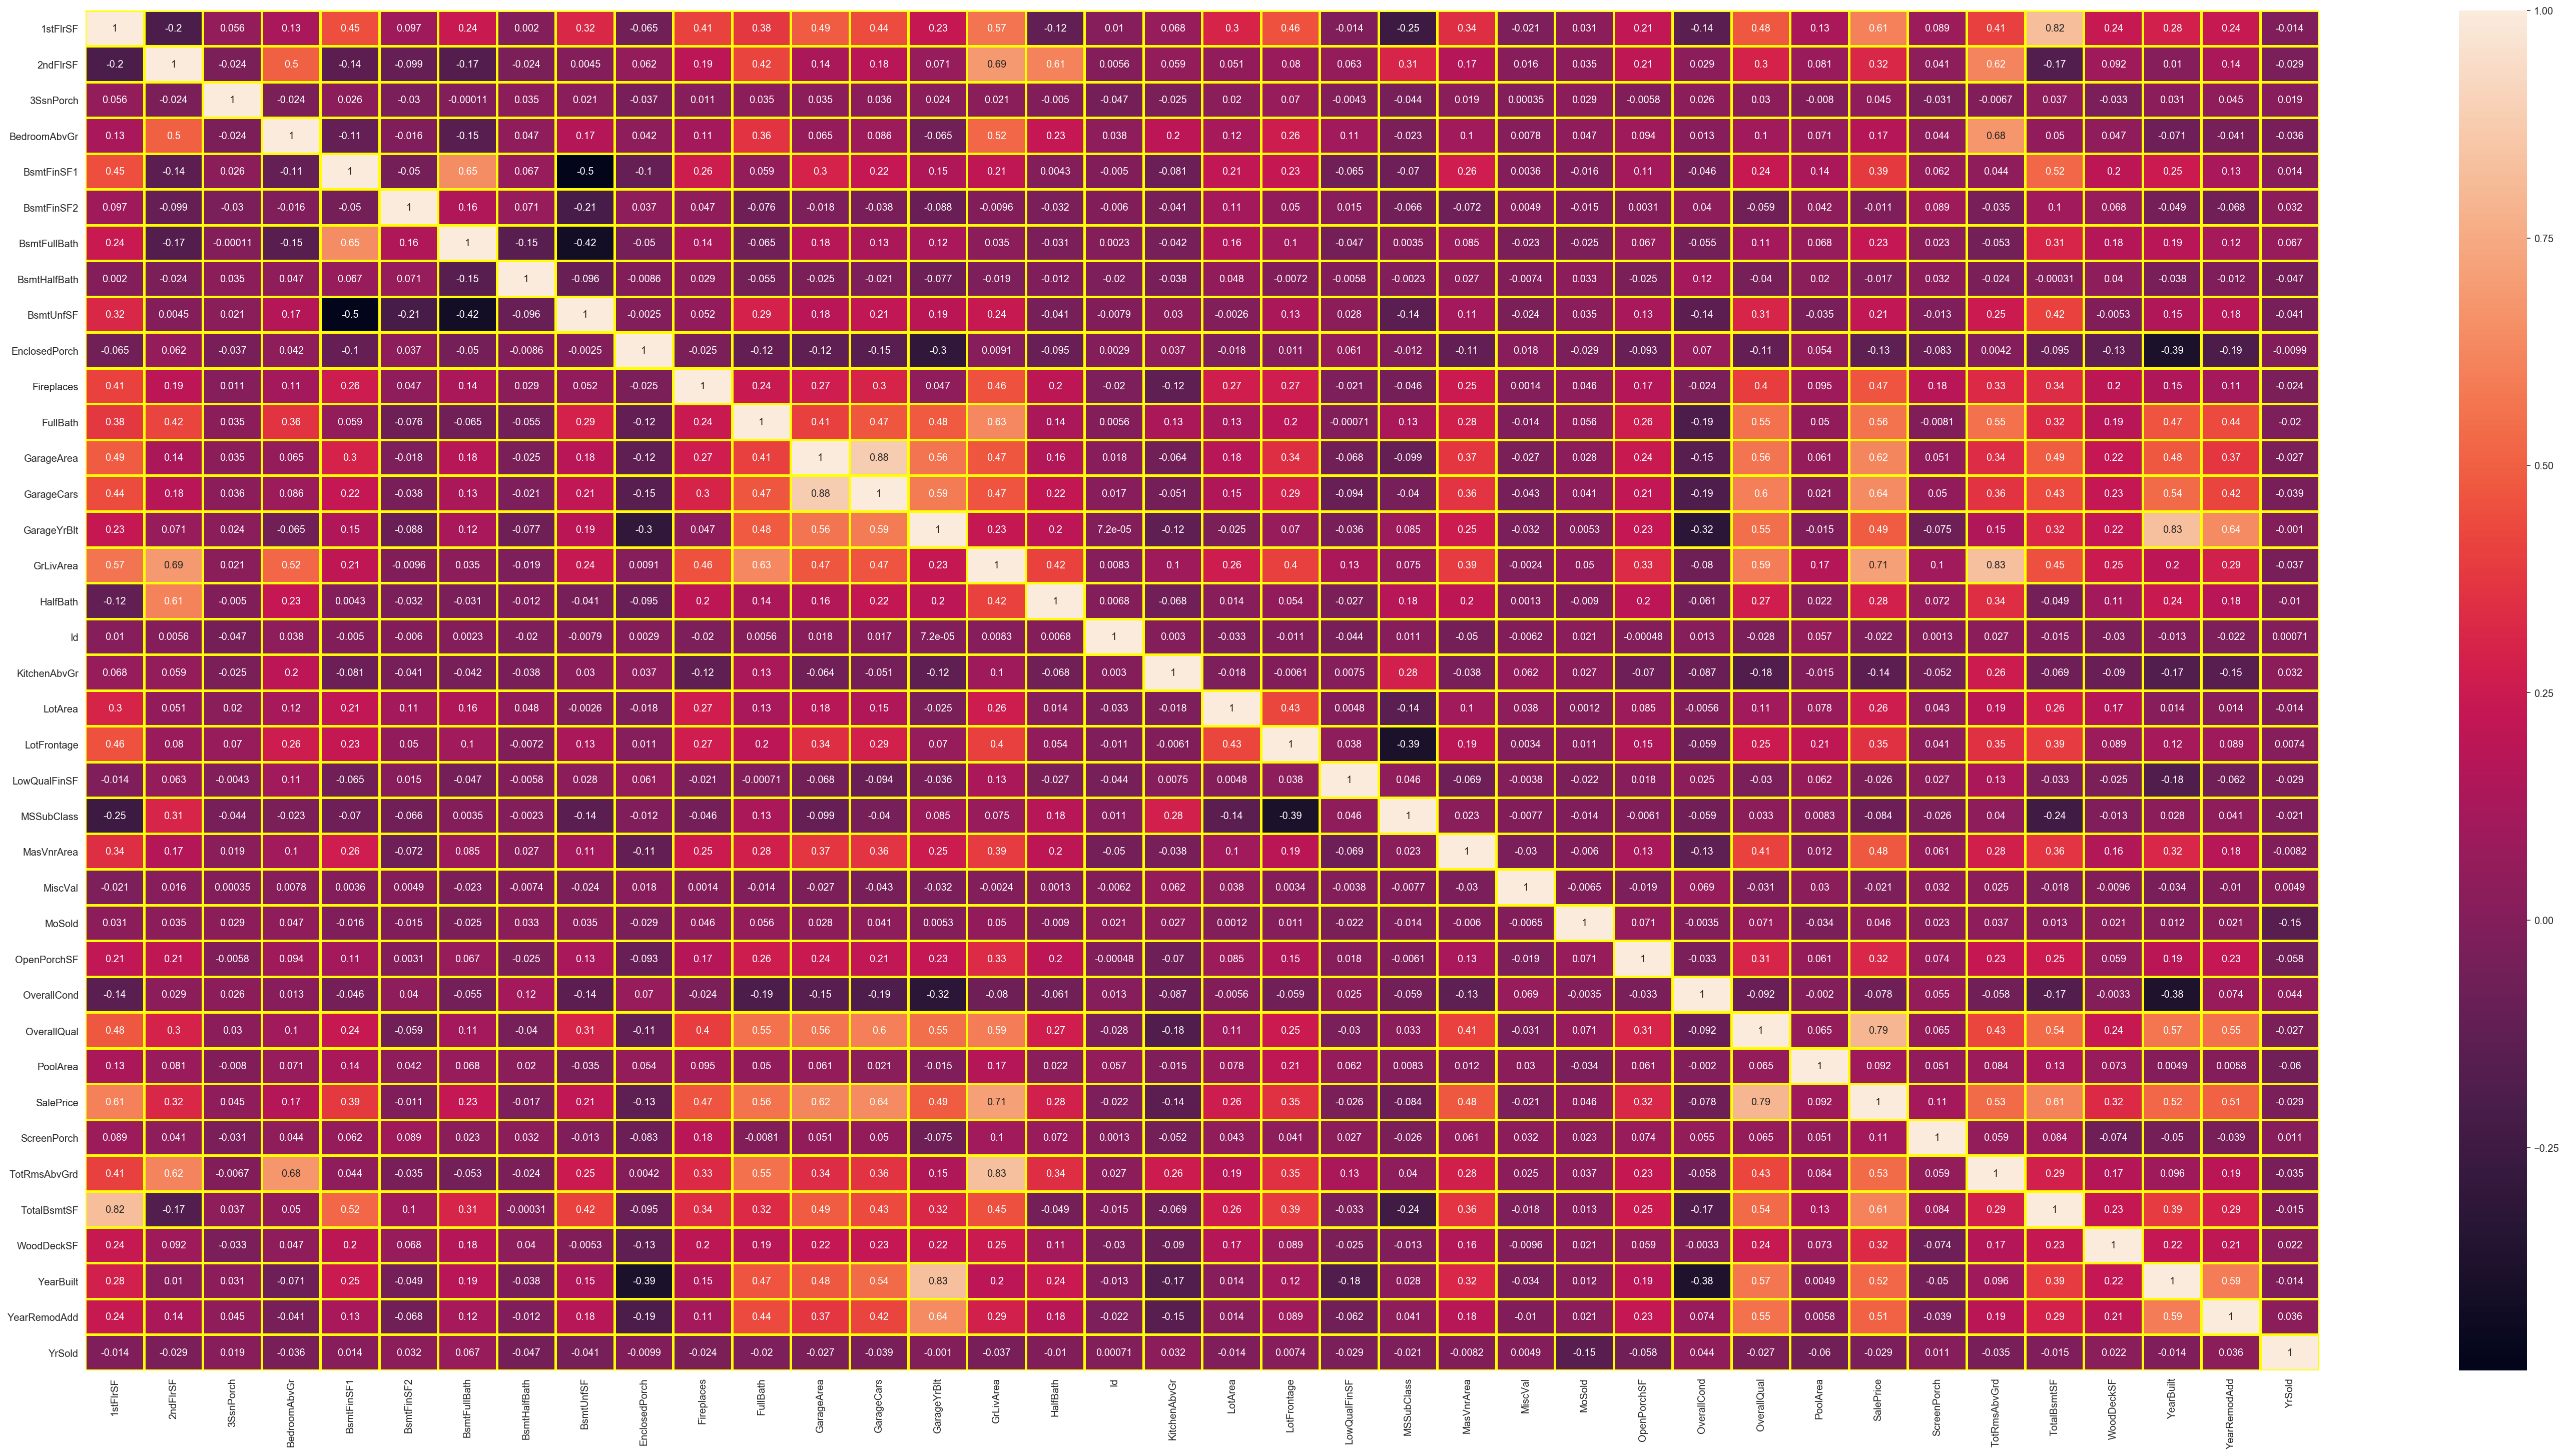

In [14]:
#to find correlation
plt.figure(figsize=(50,25))
sns.heatmap(Data.corr(), annot=True, linewidths=2, linecolor='yellow')

#not so clear redrawn

In [15]:
house_corr = house.corr()
house_corr

Id  MSSubClass  LotFrontage   LotArea  OverallQual  \
Id             1.000000    0.011156    -0.010601 -0.033226    -0.028365   
MSSubClass     0.011156    1.000000    -0.386347 -0.139781     0.032628   
LotFrontage   -0.010601   -0.386347     1.000000  0.426095     0.251646   
LotArea       -0.033226   -0.139781     0.426095  1.000000     0.105806   
OverallQual   -0.028365    0.032628     0.251646  0.105806     1.000000   
OverallCond    0.012609   -0.059316    -0.059213 -0.005636    -0.091932   
YearBuilt     -0.012713    0.027850     0.123349  0.014228     0.572323   
YearRemodAdd  -0.021998    0.040581     0.088866  0.013788     0.550684   
MasVnrArea    -0.050298    0.022936     0.193458  0.104160     0.411876   
BsmtFinSF1    -0.005024   -0.069836     0.233633  0.214103     0.239666   
BsmtFinSF2    -0.005968   -0.065649     0.049900  0.111170    -0.059119   
BsmtUnfSF     -0.007940   -0.140759     0.132644 -0.002618     0.308159   
TotalBsmtSF   -0.015415   -0.238518     0.392075  0.260833     0.537808   
1stFlrSF       0.010496   -0.251758     0.457181  0.299475     0.476224   
2ndFlrSF       0.005590    0.307886     0.080177  0.050986     0.295493   
LowQualFinSF  -0.044230    0.046474     0.038469  0.004779    -0.030429   
GrLivArea      0.008273    0.074853     0.402797  0.263116     0.593007   
BsmtFullBath   0.002289    0.003491     0.100949  0.158155     0.111098   
BsmtHalfBath  -0.020155   -0.002333    -0.007234  0.048046    -0.040150   
FullBath       0.005587    0.131608     0.198769  0.126031     0.550600   
HalfBath       0.006784    0.177354     0.053532  0.014259     0.273458   
BedroomAbvGr   0.037719   -0.023438     0.263170  0.119690     0.101676   
KitchenAbvGr   0.002951    0.281721    -0.006069 -0.017784    -0.183882   
TotRmsAbvGrd   0.027239    0.040380     0.352096  0.190015     0.427452   
Fireplaces    -0.019772   -0.045569     0.266639  0.271364     0.396765   
GarageYrBlt    0.000072    0.085072     0.070250 -0.024947     0.547766   
GarageCars     0.016570   -0.040110     0.285691  0.154871     0.600671   
GarageArea     0.017634   -0.098672     0.344997  0.180403     0.562022   
WoodDeckSF    -0.029643   -0.012579     0.088521  0.171698     0.238923   
OpenPorchSF   -0.000477   -0.006100     0.151972  0.084774     0.308819   
EnclosedPorch  0.002889   -0.012037     0.010700 -0.018340    -0.113937   
3SsnPorch     -0.046635   -0.043825     0.070029  0.020423     0.030371   
ScreenPorch    0.001330   -0.026030     0.041383  0.043160     0.064886   
PoolArea       0.057044    0.008283     0.206167  0.077672     0.065166   
MiscVal       -0.006242   -0.007683     0.003368  0.038068    -0.031406   
MoSold         0.021172   -0.013585     0.011200  0.001205     0.070815   
YrSold         0.000712   -0.021407     0.007450 -0.014261    -0.027347   
SalePrice     -0.021917   -0.084284     0.351799  0.263843     0.790982   

               OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
Id                0.012609  -0.012713     -0.021998   -0.050298   -0.005024   
MSSubClass       -0.059316   0.027850      0.040581    0.022936   -0.069836   
LotFrontage      -0.059213   0.123349      0.088866    0.193458    0.233633   
LotArea          -0.005636   0.014228      0.013788    0.104160    0.214103   
OverallQual      -0.091932   0.572323      0.550684    0.411876    0.239666   
OverallCond       1.000000  -0.375983      0.073741   -0.128101   -0.046231   
YearBuilt        -0.375983   1.000000      0.592855    0.315707    0.249503   
YearRemodAdd      0.073741   0.592855      1.000000    0.179618    0.128451   
MasVnrArea       -0.128101   0.315707      0.179618    1.000000    0.264736   
BsmtFinSF1       -0.046231   0.249503      0.128451    0.264736    1.000000   
BsmtFinSF2        0.040229  -0.049107     -0.067759   -0.072319   -0.050117   
BsmtUnfSF        -0.136841   0.149040      0.181133    0.114442   -0.495251   
TotalBsmtSF      -0.171098   0.391452      0.291066    0.363936    0

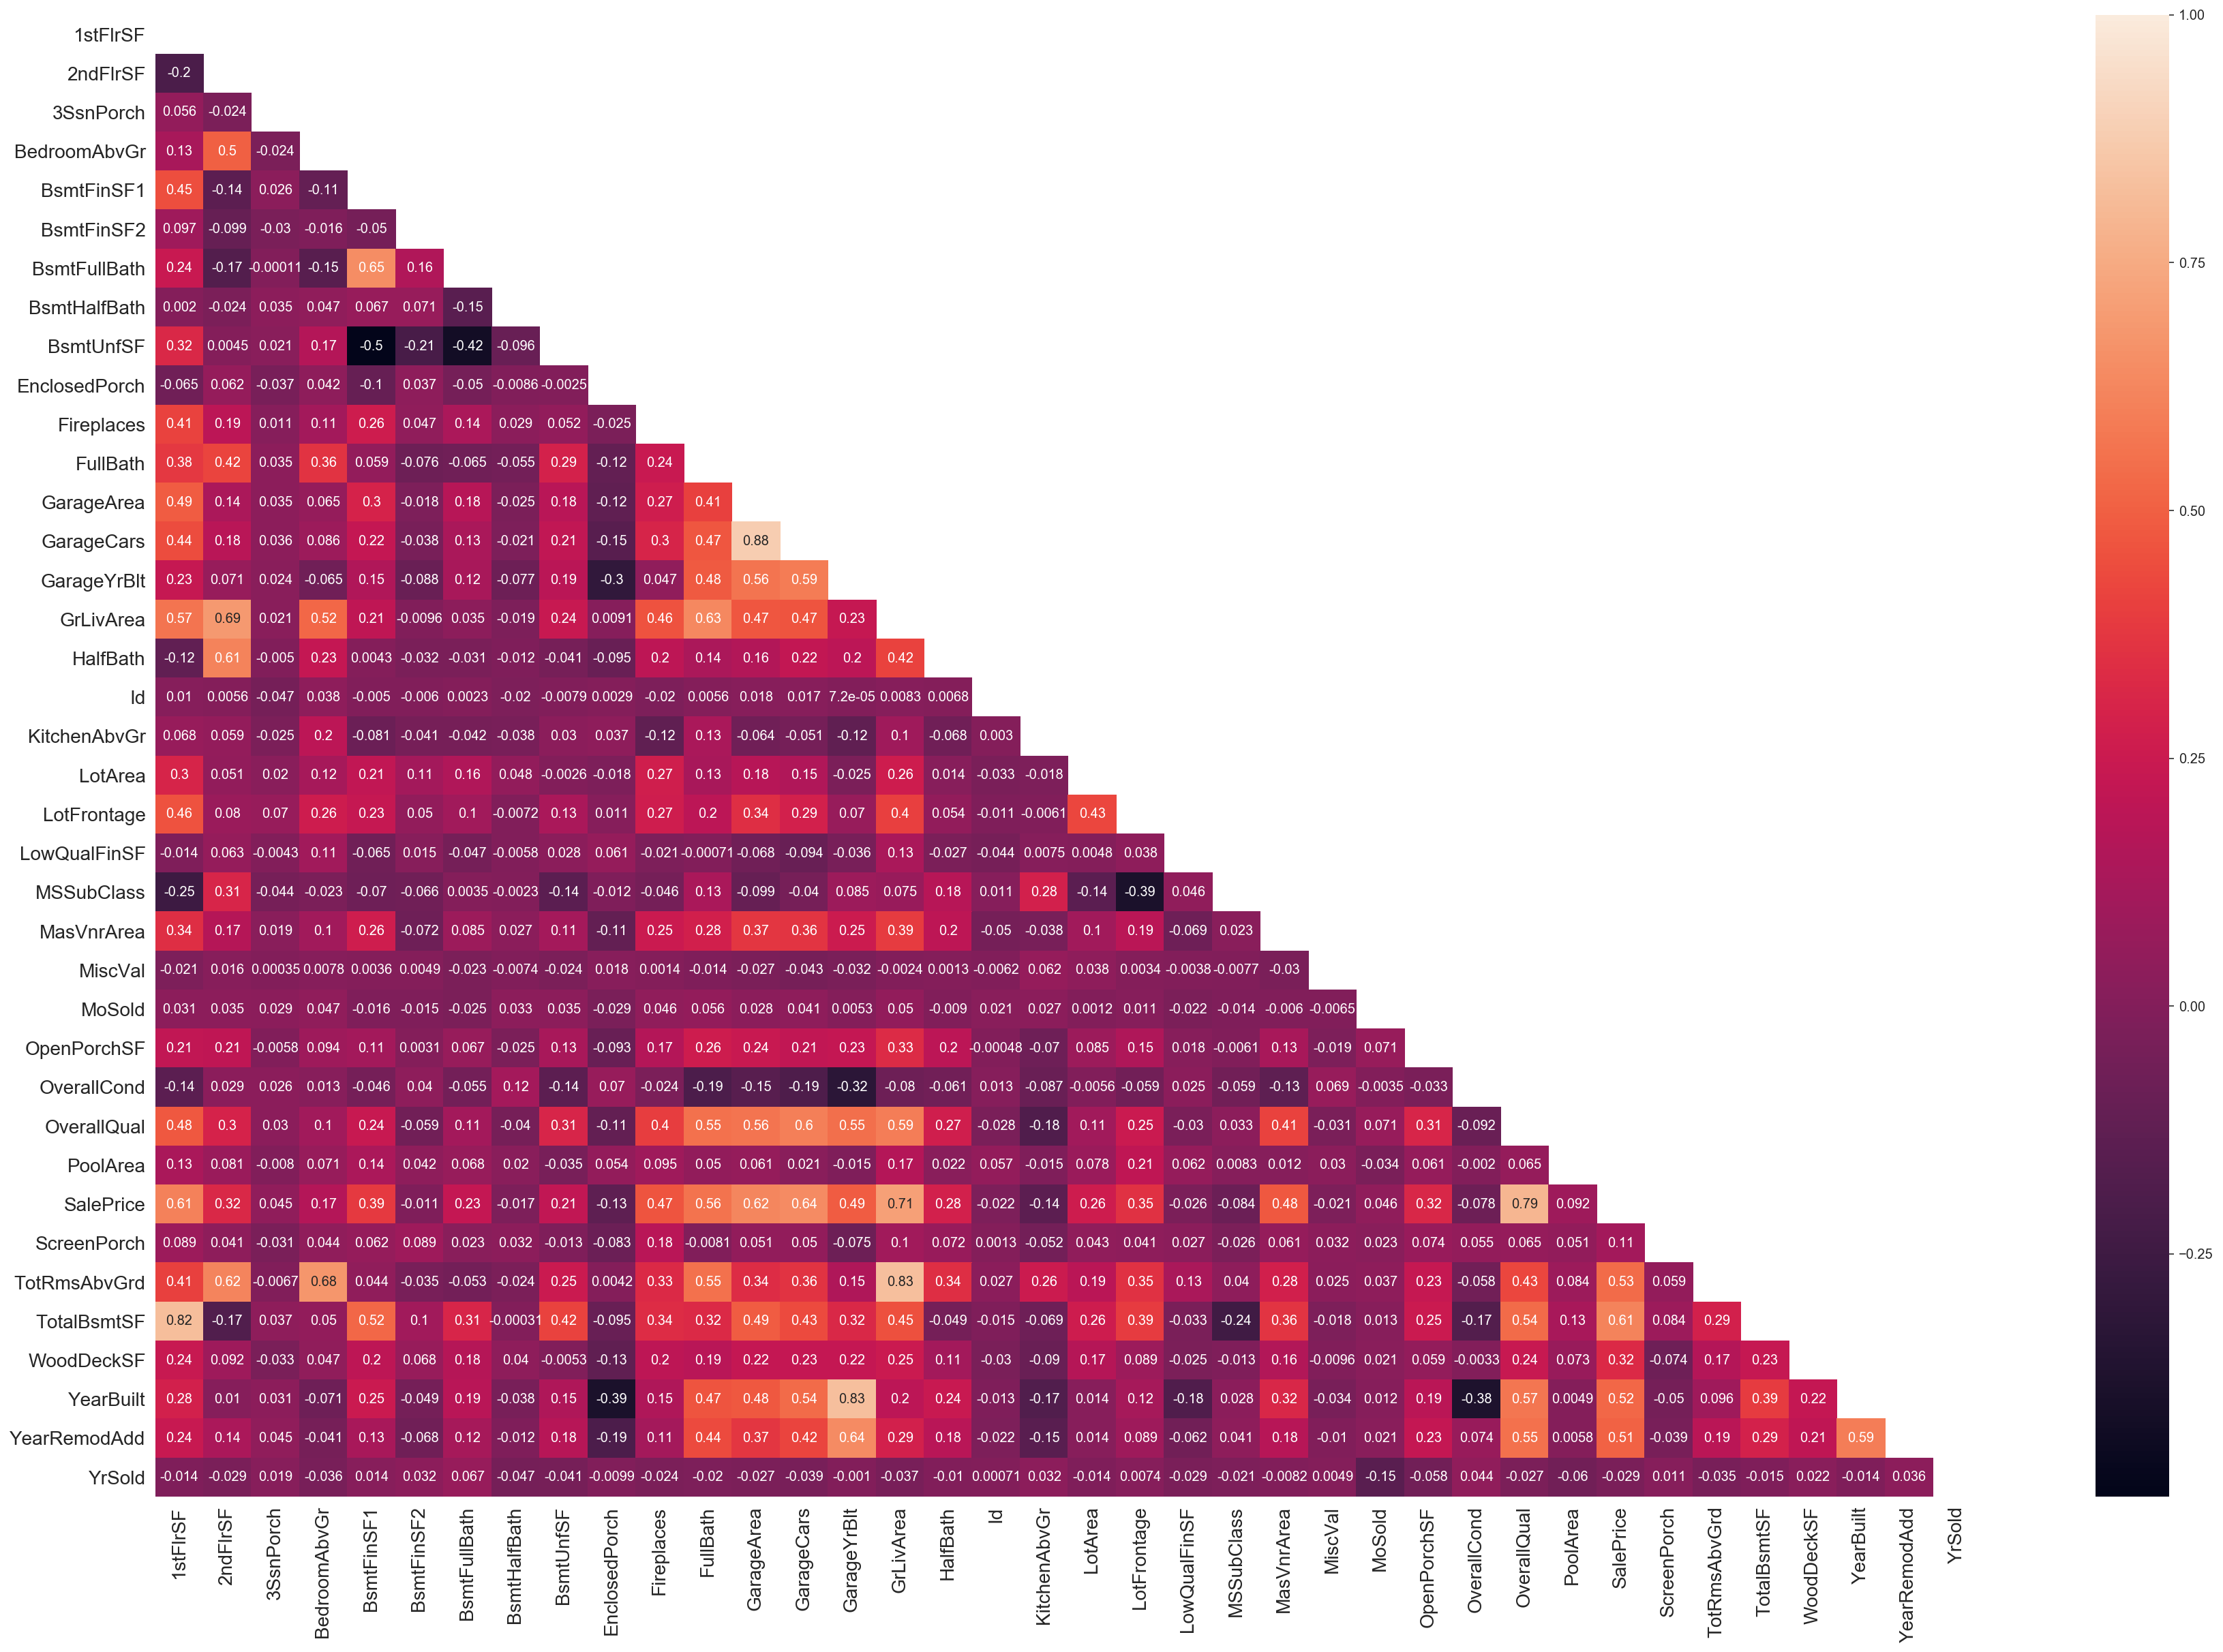

In [16]:
#redrawn correlation

# Set the default matplotlib figure size to 7x7:
fix, ax = plt.subplots(figsize=(30,20))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(Data_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(Data.corr(), mask=mask, ax=ax, annot= True)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

In [17]:
#make a copy 
house_fixed = house_fixed.copy()

In [18]:
# I find highly correlated features
#1. Garrage yr built and year built
#2. 1stFlrSF and TotalBsmtSF
#3. GrLiv Area and TotRmsAbvGrd
#4. Garage area and garage cars
#5. MSZoning also not seems to be important feature
#So I will be deleting these features which doesn't make more important

In [19]:
house_fixed.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'Foundation', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal',
       'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice'],
      dtype='object')

In [20]:
house_fixed.drop(columns=['GarageYrBlt', 'GrLivArea', 'GarageCars', '1stFlrSF', 'MSZoning'], inplace=True)


In [21]:
house_fixed.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'Foundation', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal',
       'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice'],
      dtype='object')

In [22]:
house_fixed.shape #great it's been deleted

(1460, 60)

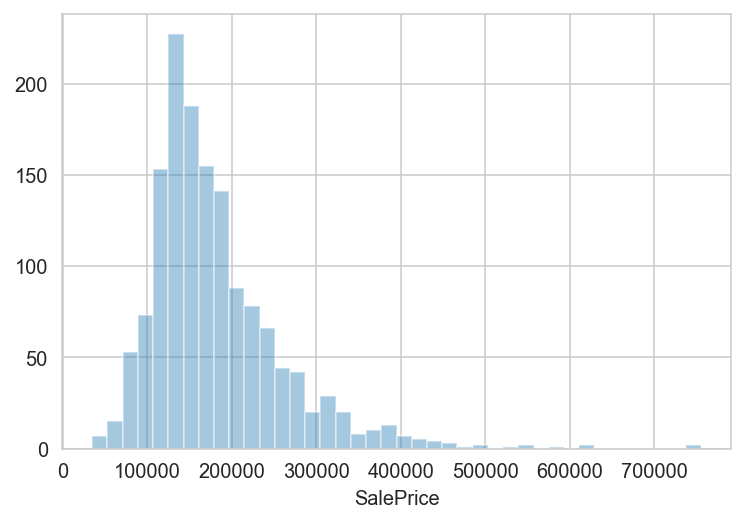

In [23]:
# Now will have a look at distribution of sale price
sns.distplot(house_fixed.SalePrice, kde=False, bins=40)  #right skewed

In [24]:
# # IMPUTING MISSING VALUES
def fill_missing_values(house_fixed):
    
     #This function imputes missing values with median for numeric columns 
        #and most frequent value for categorical columns'''
   
    missing = house_fixed.isnull().sum()
    missing = missing[missing > 0]
    for column in list(missing.index):
        if house_fixed[column].dtype == 'object':
            house_fixed[column].fillna(house_fixed[column].value_counts().index[0], inplace=True)
        elif house_fixed[column].dtype == 'int' or 'float':
            house_fixed[column].fillna(house_fixed[column].median(), inplace=True)

In [25]:
fill_missing_values(house_fixed)
house_fixed.isnull().sum().max() #Great!! now no missing values in fixed characteristics data

0

In [26]:
house_fixed.head()

Id  MSSubClass  LotFrontage  LotArea Street Alley LotShape LandContour  \
0   1          60         65.0     8450   Pave  Grvl      Reg         Lvl   
1   2          20         80.0     9600   Pave  Grvl      Reg         Lvl   
2   3          60         68.0    11250   Pave  Grvl      IR1         Lvl   
3   4          70         60.0     9550   Pave  Grvl      IR1         Lvl   
4   5          60         84.0    14260   Pave  Grvl      IR1         Lvl   

  Utilities LotConfig  ... PoolArea PoolQC  Fence MiscFeature MiscVal MoSold  \
0    AllPub    Inside  ...        0     Gd  MnPrv        Shed       0      2   
1    AllPub       FR2  ...        0     Gd  MnPrv        Shed       0      5   
2    AllPub    Inside  ...        0     Gd  MnPrv        Shed       0      9   
3    AllPub    Corner  ...        0     Gd  MnPrv        Shed       0      2   
4    AllPub       FR2  ...        0     Gd  MnPrv        Shed       0     12   

   YrSold  SaleType  SaleCondition  SalePrice  
0    2008        WD         Normal     208500  
1    2007        WD         Normal     181500  
2    2008        WD         Normal     223500  
3    2006        WD        Abnorml     140000  
4    2008        WD         Normal     250000  

[5 rows x 60 columns]

**Explore Data**

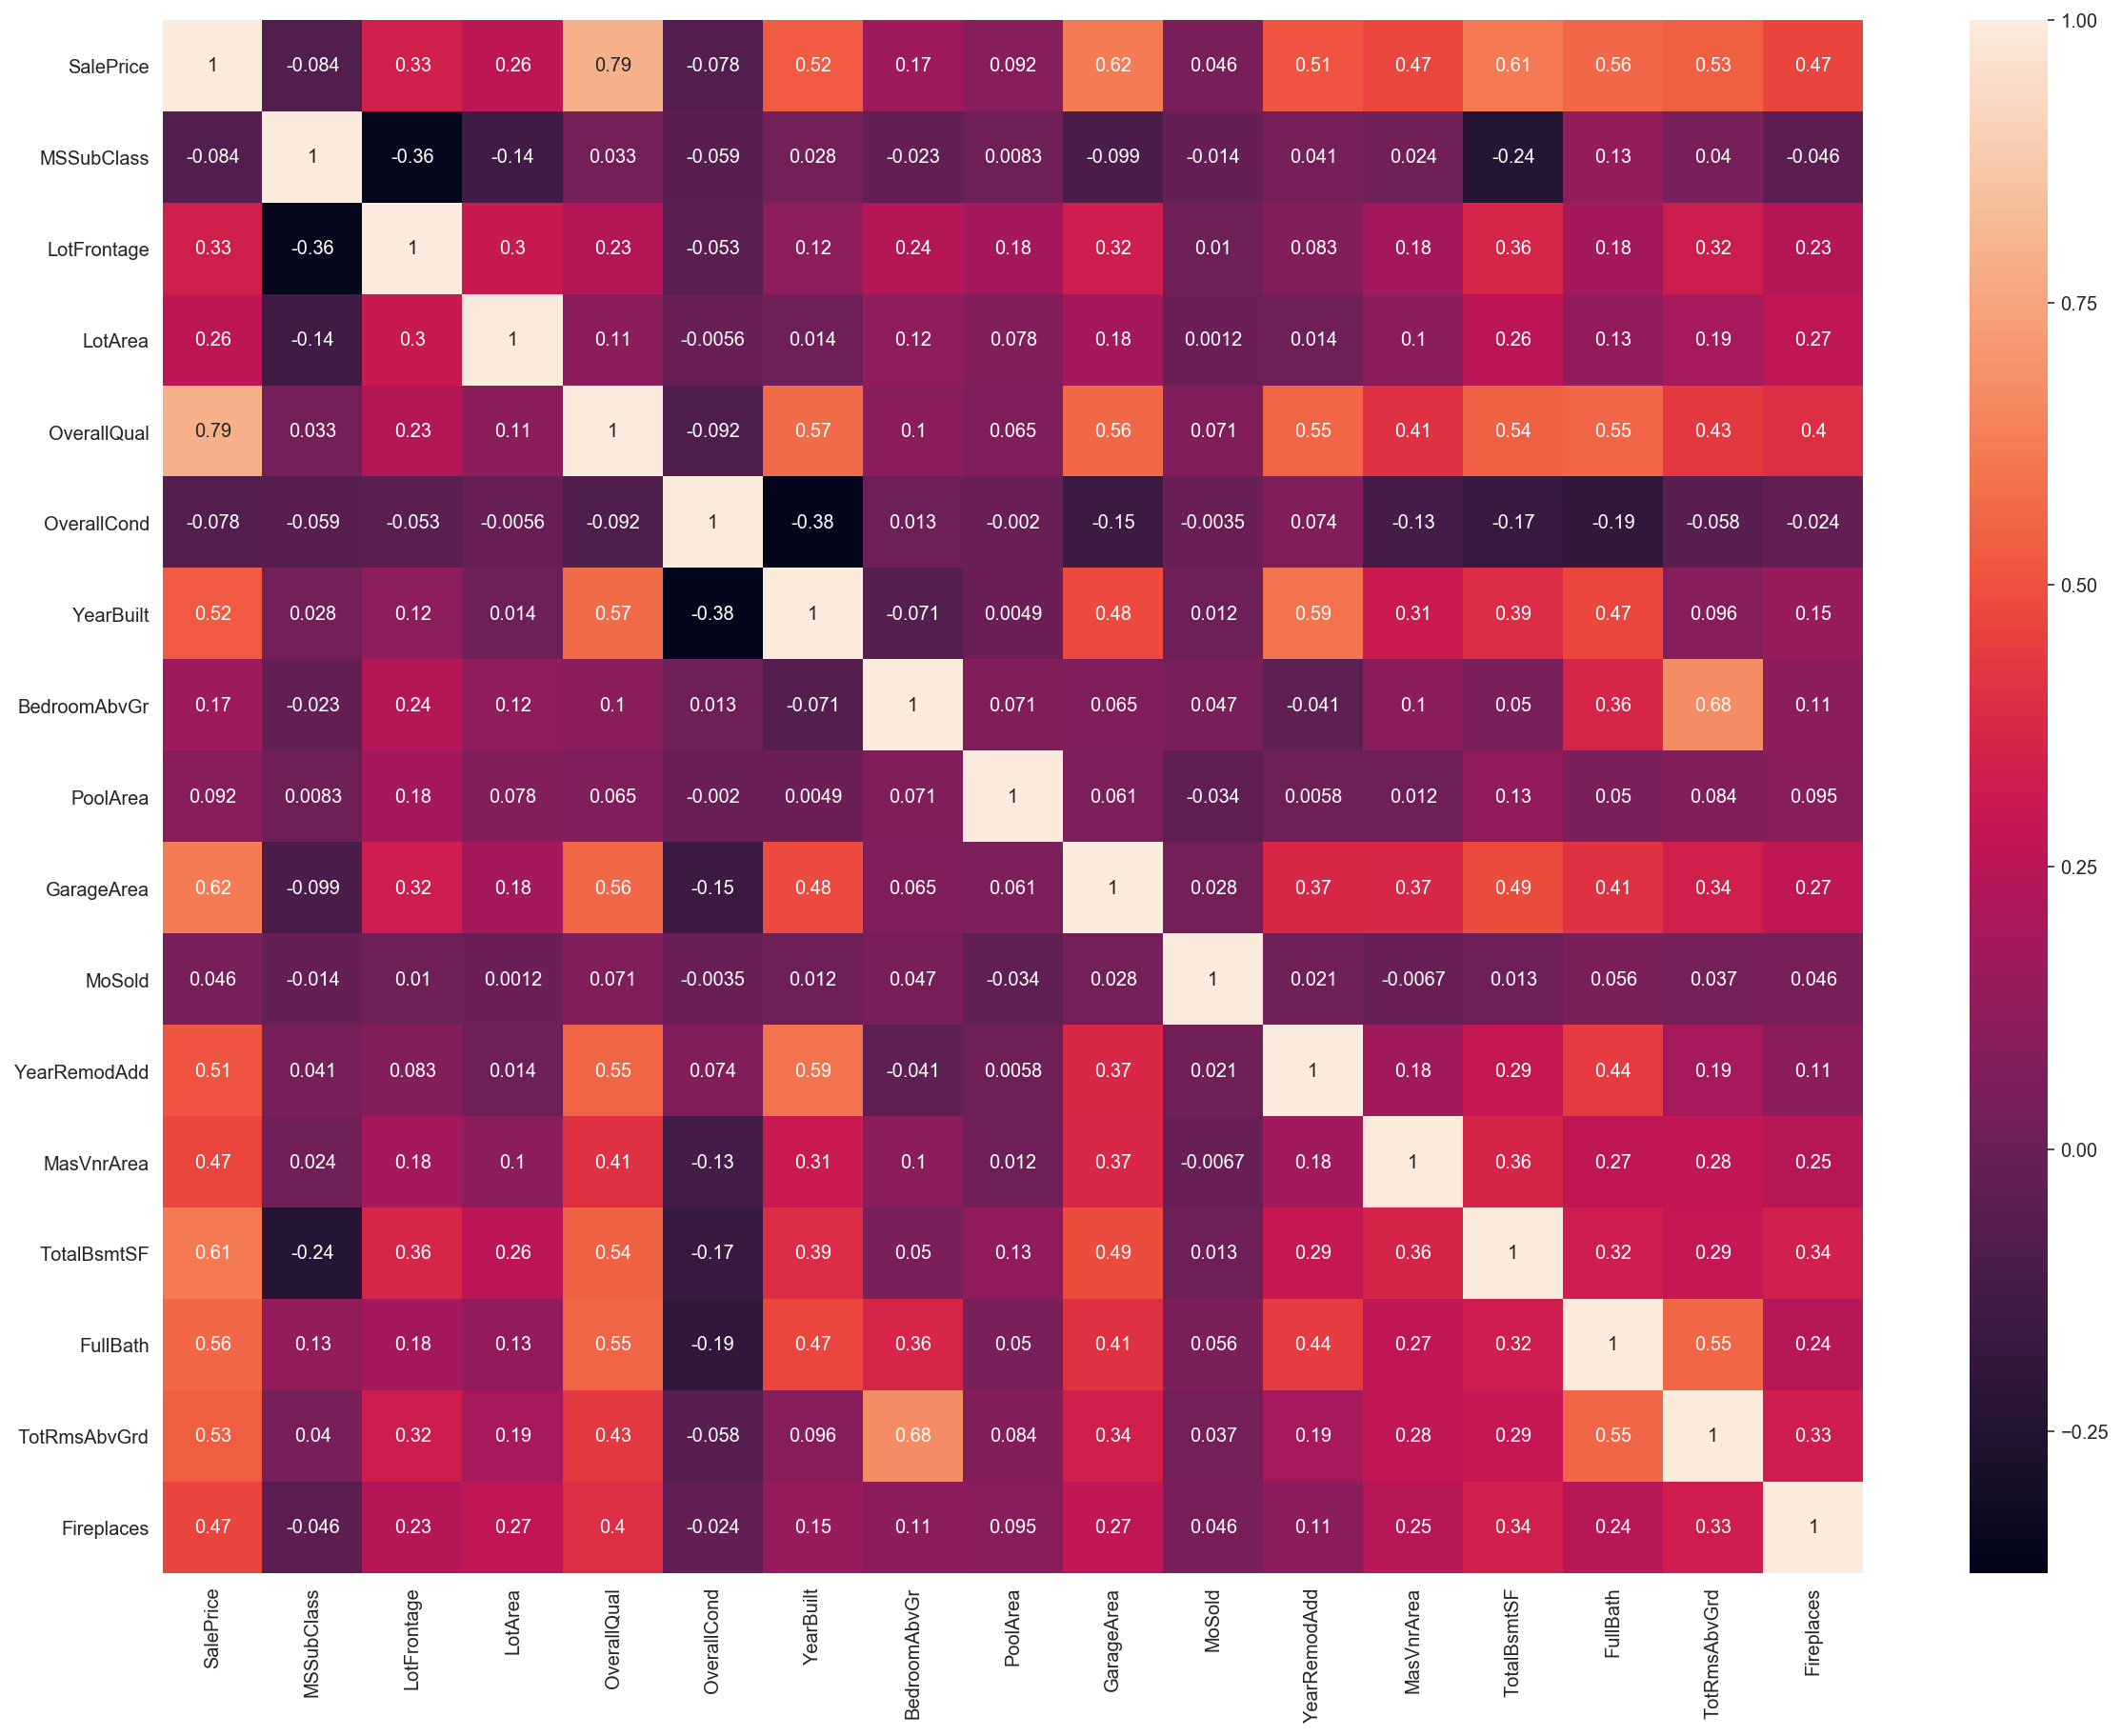

In [27]:
#Let's will have a look at data
corr_matrix = house_fixed[["SalePrice","MSSubClass","LotFrontage","LotArea", "BldgType",
                       "OverallQual", "OverallCond","YearBuilt", "BedroomAbvGr", "PoolArea", "GarageArea",
                       "SaleType", "MoSold", "YearRemodAdd", "MasVnrArea", "TotalBsmtSF", "FullBath", "TotRmsAbvGrd",
                       "Fireplaces"]].corr()

fix, ax = plt.subplots(figsize=(20,15))

ax=sns.heatmap(corr_matrix,annot=True)


With this heatmap, OVerallQual, YearBuilt, Garage area looks highly correlated with sale price. This means, these are important features in determining sale price of a house. Now, let's visualise these parameters one by one.

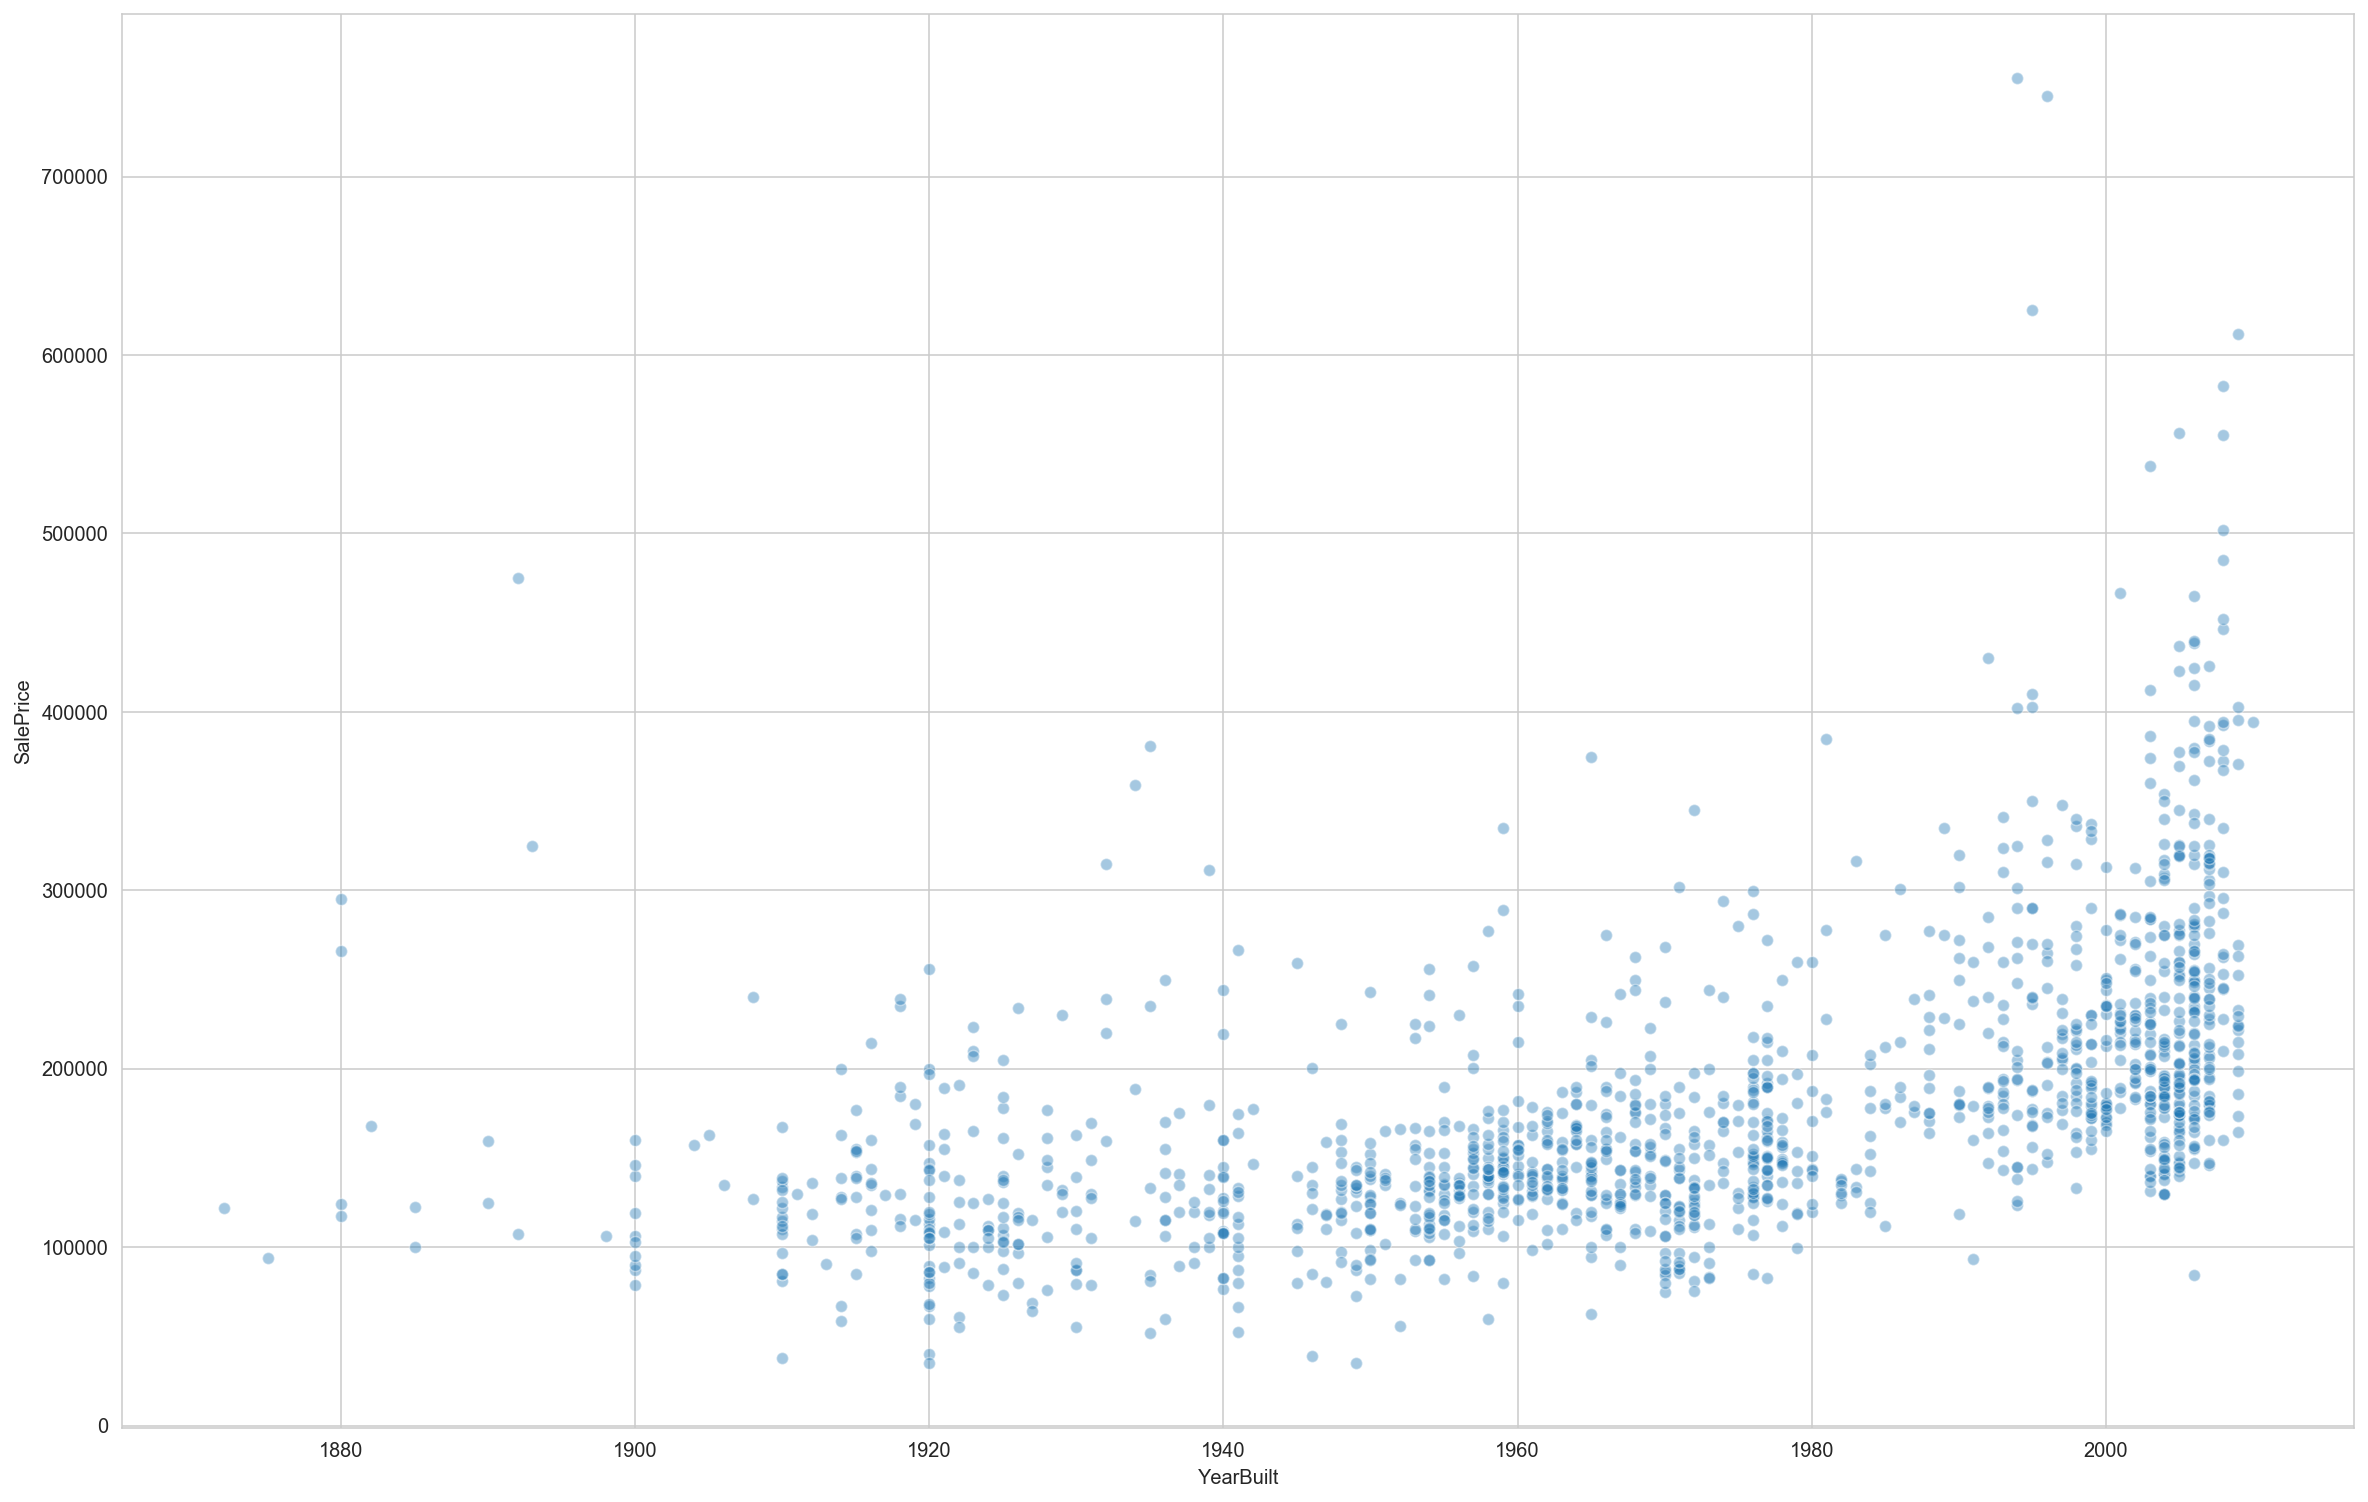

In [28]:
ax = plt.subplots(figsize=(20, 13))
sns.scatterplot(x='YearBuilt', y='SalePrice', data=house, alpha = 0.4)

It's pretty interesting increased sale price in 1890's and dropped drastically in late 1890's. 
Other point is there is siginificant increase in sale price from 1980's

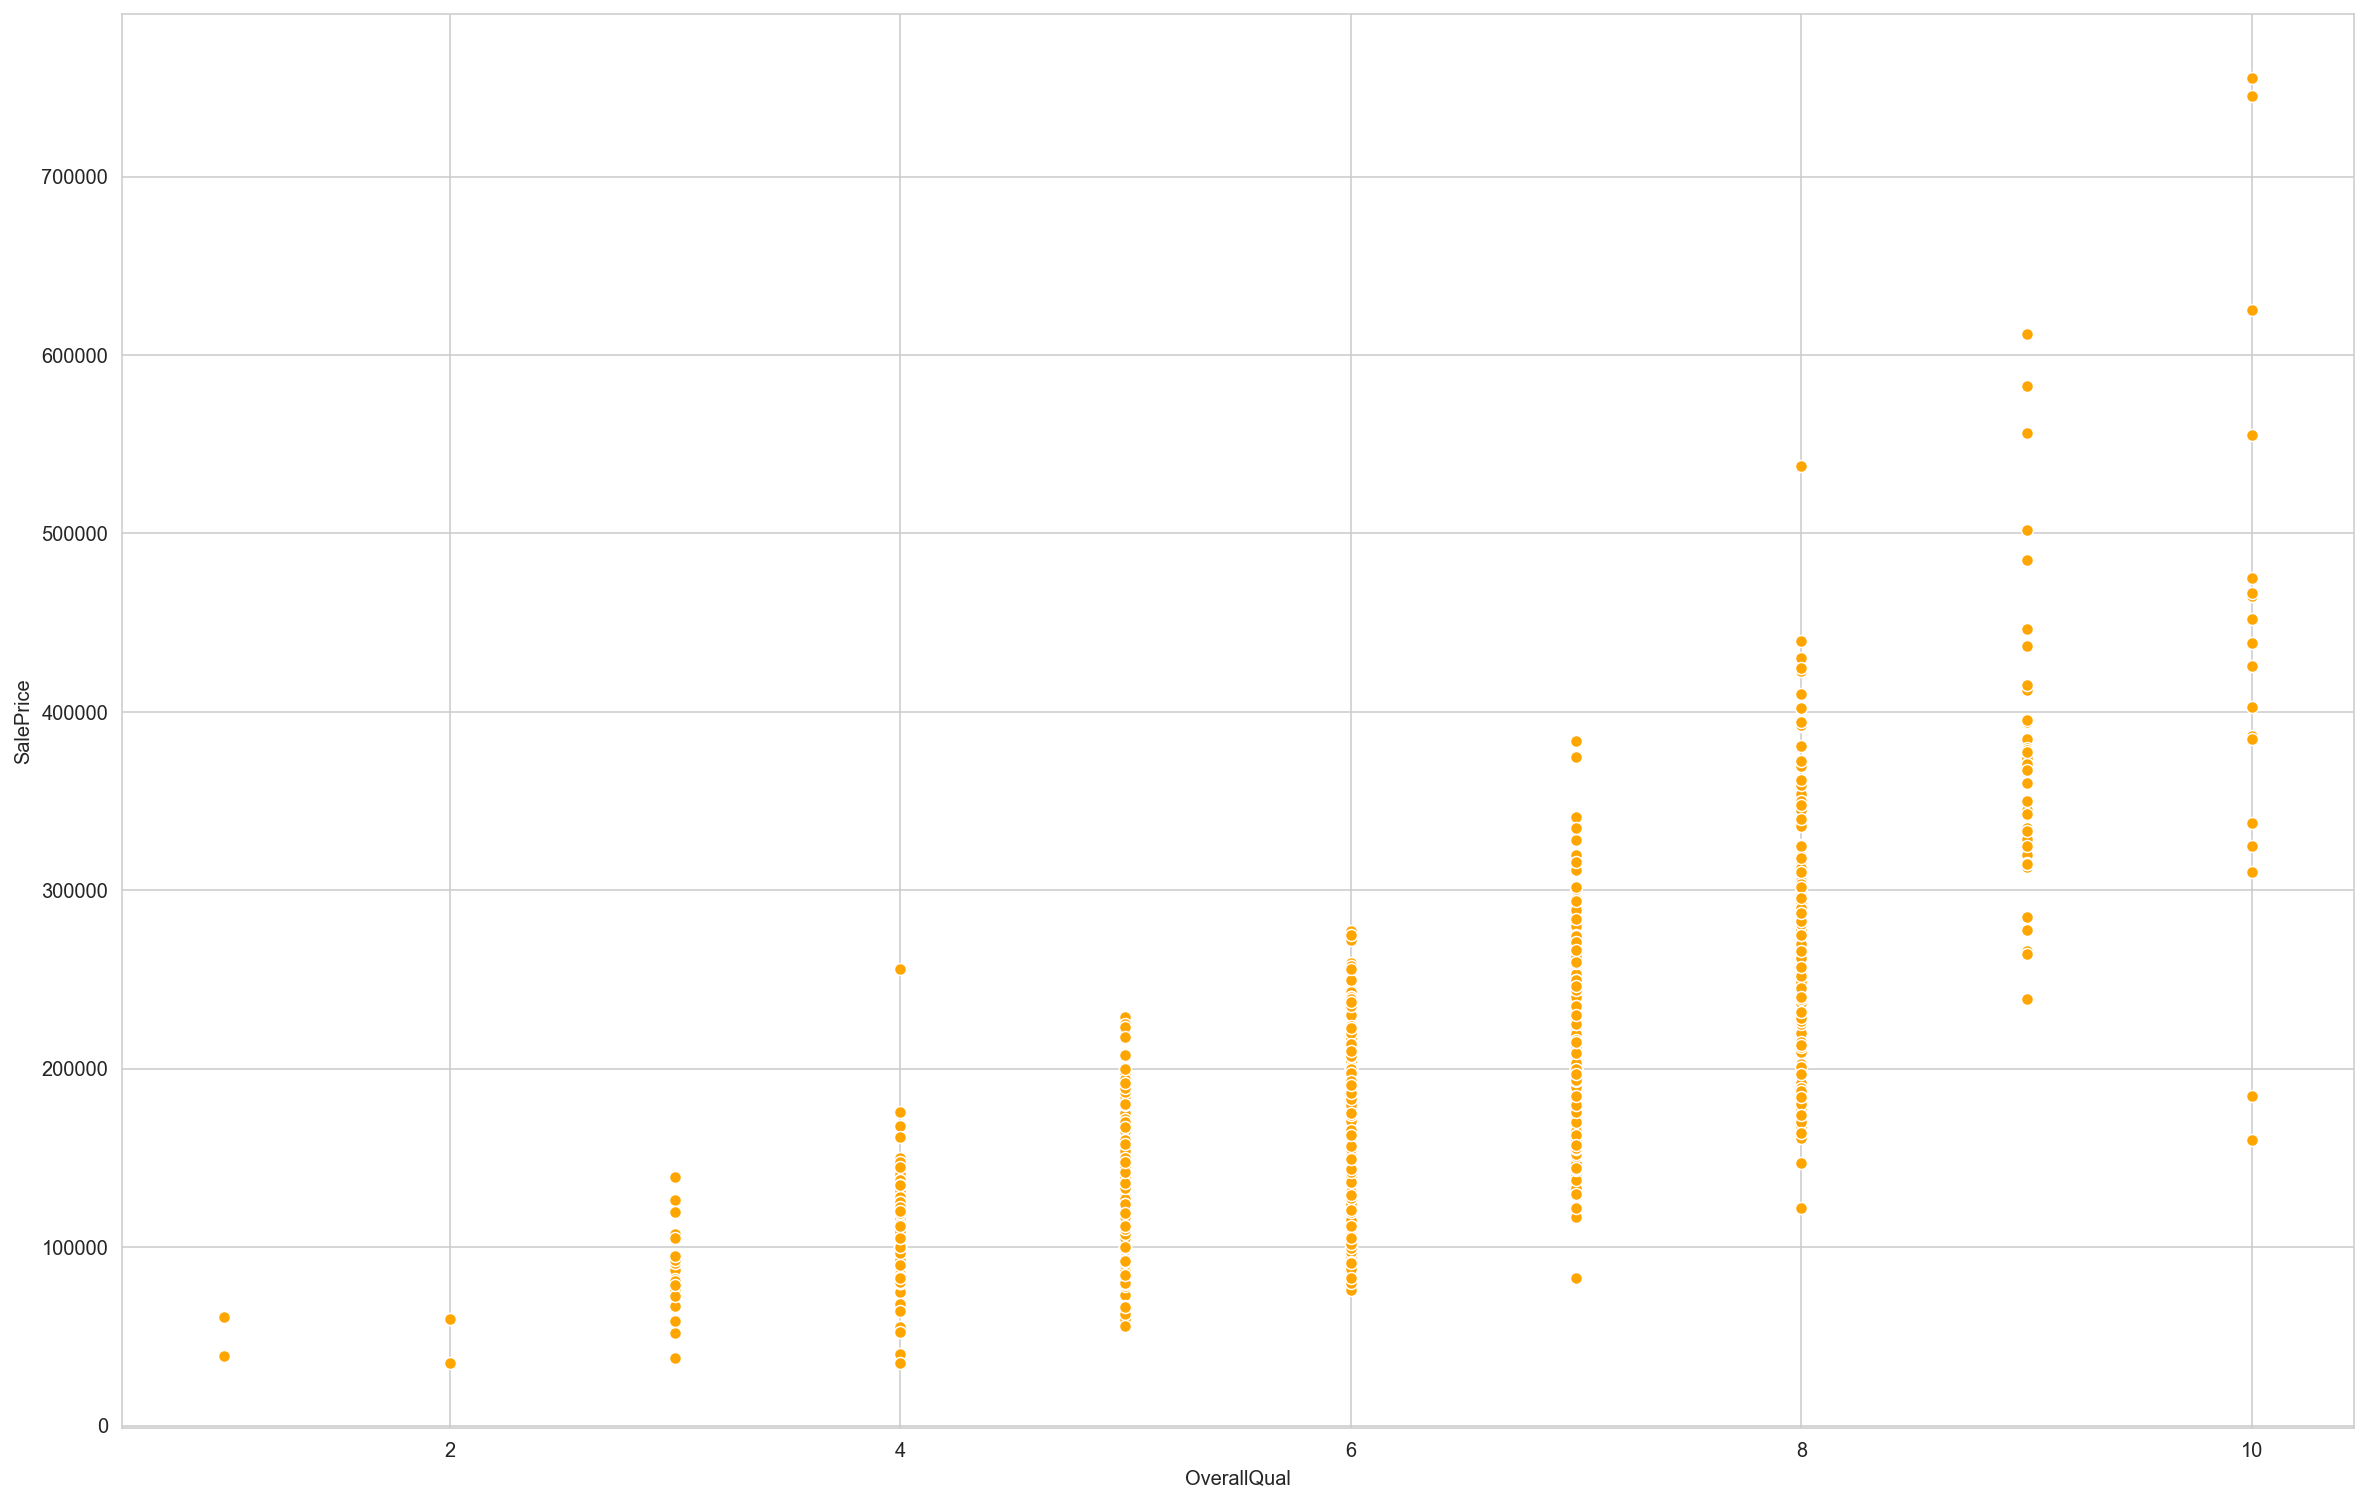

In [29]:
ax = plt.subplots(figsize=(20, 13))
sns.scatterplot(x='OverallQual', y='SalePrice', color='orange', data=house)

This graph clearly shows Sale price increases with overall quality

**Preprocessing**

In [30]:
# these need to be renamed for patsy
house_fixed.rename(columns={'2ndFlrSF':'SecondFlrSF', '1stFlrSF':'FirstFlrSF', '3SsnPorch':'ThirdSsnPorch'}, inplace=True)

In [31]:
#make a formula for Patsy
f = '''
SalePrice ~ MSSubClass + LotFrontage + LotArea + Street + Alley + LotShape + LandContour + 
Utilities + LotConfig + LandSlope + Neighborhood + Condition1 + Condition2 + BldgType + HouseStyle + 
OverallQual + OverallCond + YearBuilt + YearRemodAdd +MasVnrType + MasVnrArea + Foundation + 
BsmtExposure + BsmtFinType1 + BsmtFinSF1 + BsmtFinType2 + BsmtFinSF2 + BsmtUnfSF + TotalBsmtSF +Heating +
SecondFlrSF + LowQualFinSF + BsmtFullBath + BsmtHalfBath + FullBath + HalfBath + BedroomAbvGr + KitchenAbvGr + 
TotRmsAbvGrd + Functional + Fireplaces +GarageType + GarageArea + WoodDeckSF + OpenPorchSF + 
EnclosedPorch + ThirdSsnPorch + ScreenPorch + PoolArea + PoolQC + Fence + MiscFeature + MiscVal + MoSold +
YrSold + SaleType + SaleCondition -1
'''

In [32]:
import patsy

In [33]:
# get the recent year indices for testing
recent = house.YrSold == 2010

In [34]:
# Make the X, y from formula
y, X = patsy.dmatrices(f, data=house_fixed, return_type='dataframe')
y = y.values.ravel()
print (y.shape, X.shape)

(1460,) (1460, 156)


In [35]:
# Standardize X before splitting
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs = ss.fit_transform(X)

In [36]:
# make training and testing set (test is 2010)
Xtr, Xte = Xs[~recent], Xs[recent]
ytr, yte = y[~recent], y[recent]

In [37]:
Xtr = pd.DataFrame(Xtr, columns=X.columns)
Xte = pd.DataFrame(Xte, columns=X.columns)

In [38]:
print (Xtr.shape, Xte.shape)

(1285, 156) (175, 156)


Prepare training and testing splits

In [39]:
from sklearn.linear_model import LassoCV

In [40]:
lasso_cv = LassoCV(n_alphas=300, cv=10, verbose=1)
lasso_cv.fit(Xtr, ytr)
# test the lasso model using the testing data
lasso_cv.score(Xtr, ytr)
lasso_cv.score(Xte, yte)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.8480568043604914

**Plot the predicted price against the actual price**

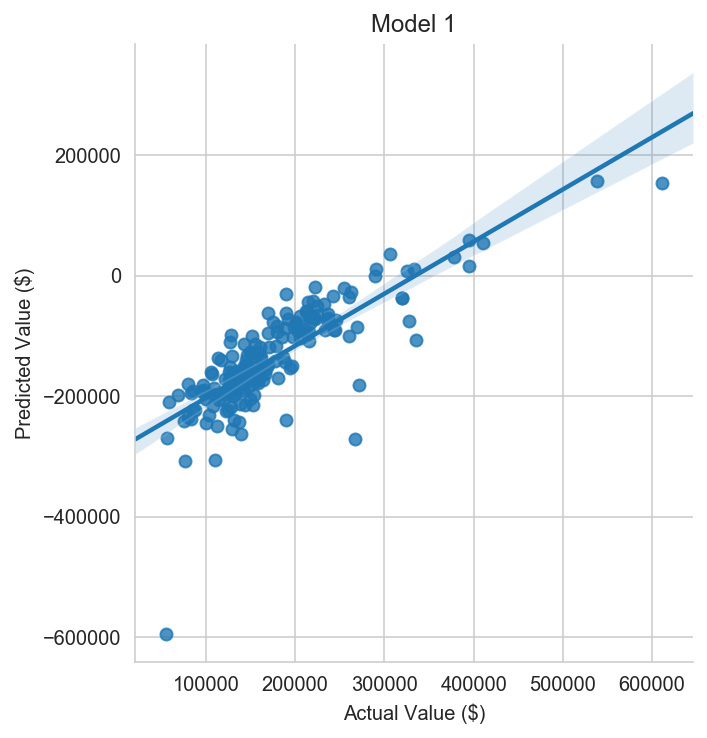

In [41]:
model = sm.OLS(ytr, Xtr).fit()
helper = pd.DataFrame()
helper['Actual Value ($)'] = yte
helper['Predicted Value ($)'] = model.predict(Xte)
sns.lmplot(x='Actual Value ($)', y='Predicted Value ($)', data = helper);
ax = plt.gca()
ax.set_title("Model 1");

There are few outliers. This plot is ok to move forward.

In [42]:
mean_mse = np.array([np.mean(x) for x in lasso_cv.mse_path_])
std_mse = np.array([np.std(x) for x in lasso_cv.mse_path_])
alphas = lasso_cv.alphas_

best alpha =2020.4513550120375


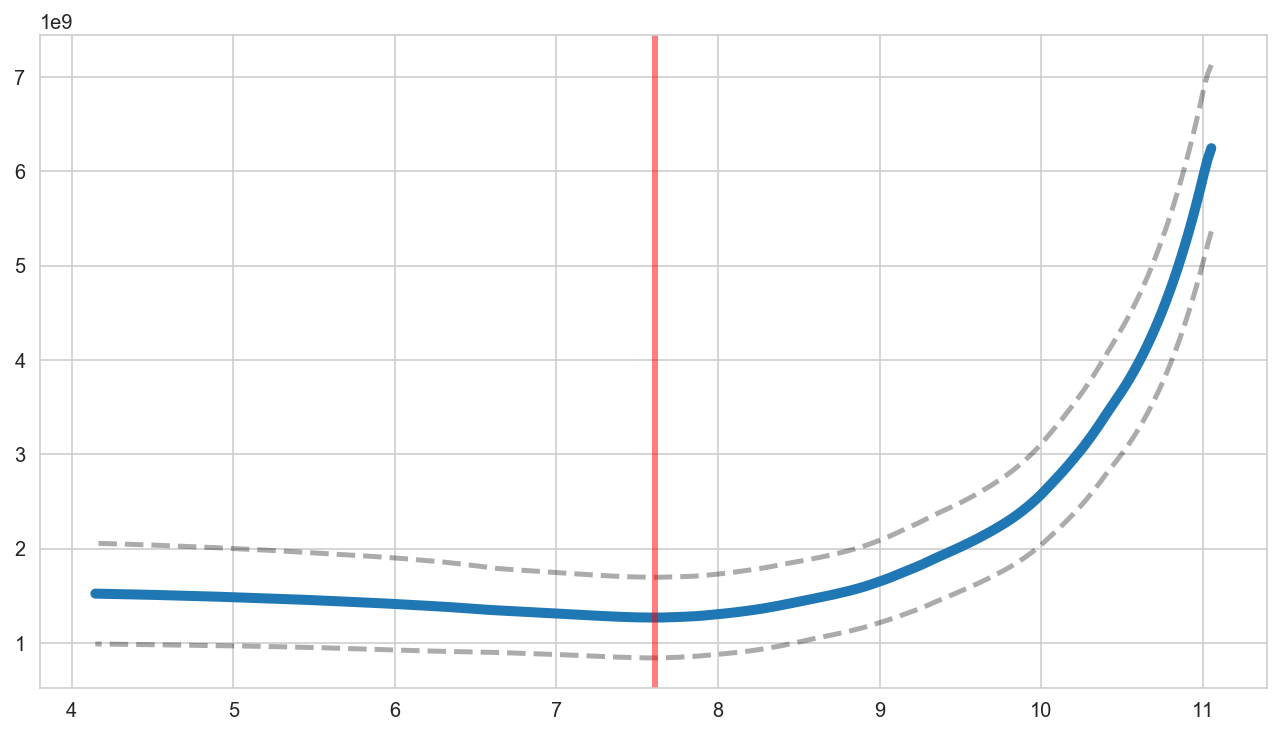

In [43]:
std_plus = mean_mse+std_mse/2.
std_minus = mean_mse-std_mse/2.

fig, ax = plt.subplots(figsize=(11,6))

ln_alphas = np.log(alphas)

ax.plot(ln_alphas, mean_mse, lw=5)

ax.plot(ln_alphas, std_plus, lw=2.5, ls='dashed', c='black', alpha=0.33)
ax.plot(ln_alphas, std_minus, lw=2.5, ls='dashed', c='black', alpha=0.33)

min_mse = np.min(mean_mse)
best_alpha = np.where(mean_mse == min_mse)[0][-1]

ax.axvline(x=ln_alphas[best_alpha], lw=3, c='red', alpha=0.5)
print ('best alpha =' + str(np.exp(ln_alphas[best_alpha])))
plt.show()

**Strong predictors**

In [44]:
lasso_coefs = pd.DataFrame(dict(feature=X.columns, coef=lasso_cv.coef_, abscoef=np.abs(lasso_cv.coef_)))
lasso_coefs.sort_values('abscoef', inplace=True, ascending=False)
lasso_coefs[lasso_coefs.coef != 0].reset_index(drop=True)

feature          coef       abscoef
0               OverallQual  24832.135854  24832.135854
1              TotRmsAbvGrd   9213.687206   9213.687206
2   Neighborhood[T.NoRidge]   9152.968925   9152.968925
3   Neighborhood[T.NridgHt]   8345.413848   8345.413848
4                GarageArea   7951.955443   7951.955443
5               TotalBsmtSF   6894.400343   6894.400343
6                MSSubClass  -5656.049666   5656.049666
7               SecondFlrSF   5461.665135   5461.665135
8   Neighborhood[T.StoneBr]   5162.735252   5162.735252
9                Fireplaces   5129.614356   5129.614356
10          SaleType[T.New]   5056.748408   5056.748408
11                 FullBath   4812.869675   4812.869675
12       BsmtExposure[T.Gd]   4707.530743   4707.530743
13             YearRemodAdd   4000.775701   4000.775701
14               BsmtFinSF1   3266.842240   3266.842240
15                  LotArea   3235.427260   3235.427260
16      BsmtFinType1[T.GLQ]   2917.609015   2917.609015
17  Neighborhood[T.Crawfor]   2896.925580   2896.925580
18       Condition2[T.PosN]  -2873.154544   2873.154544
19       BsmtExposure[T.No]  -2683.049011   2683.049011
20               MasVnrArea   2576.364059   2576.364059
21               WoodDeckSF   2438.649176   2438.649176
22             PoolQC[T.Gd]  -2115.790758   2115.790758
23              OverallCond   1989.991854   1989.991854
24     LotConfig[T.CulDSac]   1555.027931   1555.027931
25                YearBuilt   1409.926566   1409.926566
26             BsmtFullBath   1331.047804   1331.047804
27              ScreenPorch   1028.078050   1028.078050
28       Condition1[T.Norm]   1010.221878   1010.221878
29    GarageType[T.BuiltIn]    993.684398    993.684398
30                 HalfBath    918.613502    918.613502
31          LotShape[T.IR3]   -740.667367    740.667367
32  Neighborhood[T.Veenker]    724.521358    724.521358
33  Neighborhood[T.Somerst]    676.320343    676.320343
34          LotShape[T.IR2]    658.596661    658.596661
35              OpenPorchSF    537.741161    537.741161
36  Neighborhood[T.OldTown]   -510.509029    510.509029
37             KitchenAbvGr   -402.060108    402.060108
38         LandSlope[T.Mod]    267.036634    267.036634
39      BsmtFinType1[T.Unf]   -264.006006    264.006006
40        BldgType[T.Twnhs]   -149.876644    149.876644

Lasso effectively kept only 40 features

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [45]:
#The features can be choosen for renovations

renovateable_features = house[['RoofStyle','RoofMatl','Exterior1st','ExterCond',
              'BsmtCond','HeatingQC','CentralAir','Electrical',
              'GarageFinish','GarageCond','PavedDrive',
              'ExterQual','BsmtQual','GarageQual','KitchenQual',
              'FireplaceQu']]

In [46]:
renovateable_features.head()

RoofStyle RoofMatl Exterior1st ExterCond BsmtCond HeatingQC CentralAir  \
0     Gable  CompShg     VinylSd        TA       TA        Ex          Y   
1     Gable  CompShg     MetalSd        TA       TA        Ex          Y   
2     Gable  CompShg     VinylSd        TA       TA        Ex          Y   
3     Gable  CompShg     Wd Sdng        TA       Gd        Gd          Y   
4     Gable  CompShg     VinylSd        TA       TA        Ex          Y   

  Electrical GarageFinish GarageCond PavedDrive ExterQual BsmtQual GarageQual  \
0      SBrkr          RFn         TA          Y        Gd       Gd         TA   
1      SBrkr          RFn         TA          Y        TA       Gd         TA   
2      SBrkr          RFn         TA          Y        Gd       Gd         TA   
3      SBrkr          Unf         TA          Y        TA       TA         TA   
4      SBrkr          RFn         TA          Y        Gd       Gd         TA   

  KitchenQual FireplaceQu  
0          Gd         NaN  
1          TA          TA  
2          Gd          TA  
3          Gd          Gd  
4          Gd          TA

In [47]:
renovateable_features.corr()
renovateable_features


RoofStyle RoofMatl Exterior1st ExterCond BsmtCond HeatingQC CentralAir  \
0        Gable  CompShg     VinylSd        TA       TA        Ex          Y   
1        Gable  CompShg     MetalSd        TA       TA        Ex          Y   
2        Gable  CompShg     VinylSd        TA       TA        Ex          Y   
3        Gable  CompShg     Wd Sdng        TA       Gd        Gd          Y   
4        Gable  CompShg     VinylSd        TA       TA        Ex          Y   
5        Gable  CompShg     VinylSd        TA       TA        Ex          Y   
6        Gable  CompShg     VinylSd        TA       TA        Ex          Y   
7        Gable  CompShg     HdBoard        TA       TA        Ex          Y   
8        Gable  CompShg     BrkFace        TA       TA        Gd          Y   
9        Gable  CompShg     MetalSd        TA       TA        Ex          Y   
10         Hip  CompShg     HdBoard        TA       TA        Ex          Y   
11         Hip  CompShg     WdShing        TA       TA        Ex          Y   
12         Hip  CompShg     HdBoard        TA       TA        TA          Y   
13       Gable  CompShg     VinylSd        TA       TA        Ex          Y   
14         Hip  CompShg     MetalSd        TA       TA        TA          Y   
15       Gable  CompShg     Wd Sdng        TA       TA        Ex          Y   
16       Gable  CompShg     Wd Sdng        TA       TA        Ex          Y   
17       Gable  CompShg     MetalSd        TA      NaN        TA          Y   
18       Gable  CompShg     VinylSd        TA       TA        Ex          Y   
19         Hip  CompShg     BrkFace        TA       TA        TA          Y   
20       Gable  CompShg     VinylSd        TA       TA        Ex          Y   
21       Gable  CompShg     Wd Sdng        TA       TA        Ex          Y   
22         Hip  CompShg     VinylSd        TA       TA        Ex          Y   
23       Gable  CompShg     CemntBd        TA       TA        TA          Y   
24       Gable  CompShg     Plywood        Gd       TA        Ex          Y   
25       Gable  CompShg     VinylSd        TA       TA        Ex          Y   
26       Gable  CompShg     Wd Sdng        TA       TA        TA          Y   
27       Gable  CompShg     VinylSd        TA       TA        Ex          Y   
28       Gable  CompShg     MetalSd        TA       TA        TA          Y   
29       Gable  CompShg     MetalSd        TA       TA        Fa          N   
...        ...      ...         ...       ...      ...       ...        ...   
1430     Gable  CompShg     VinylSd        TA       Gd        Ex          Y   
1431     Gable  CompShg     Plywood        TA       TA        TA          Y   
1432     Gable  CompShg     Wd Sdng        TA       TA        TA          Y   
1433     Gable  CompShg     VinylSd        TA       TA        Ex          Y   
1434     Gable  CompShg     BrkFace        TA       TA        Fa          Y   
1435     Gable  CompShg     Wd Sdng        Gd       TA        TA          Y   
1436     Gable  CompShg     HdBoard        TA       TA        TA          Y   
1437       Hip  CompShg     VinylSd        TA       TA        Ex          Y   
1438     Gable  CompShg     MetalSd        TA       TA        TA          Y   
1439       Hip  CompShg     HdBoard        TA       TA        TA          Y   
1440     Gable  CompShg     MetalSd        TA       TA        Fa          Y   
1441     Gable  CompShg     VinylSd        TA       TA        Ex          Y   
1442     Gable  CompShg     VinylSd        TA       TA        Ex          Y   
1443     Gable  CompShg     Wd Sdng        TA       TA        Fa          N   
1444     Gable  CompShg     VinylSd        TA       TA        Ex          Y   
1445     Gable  CompShg     VinylSd        TA       TA        Gd          Y   
1446     Gable  CompShg     HdBoard        TA       TA        TA          Y   
1447     Gable  CompShg     VinylSd        TA       TA        Ex          Y   
1448     Gable  CompShg     MetalSd        TA       TA 

In [48]:
# # IMPUTING MISSING VALUES
def fill_missing_values(renovateable_features):
    
     #This function imputes missing values with median for numeric columns 
        #and most frequent value for categorical columns'''
   
    missing = renovateable_features.isnull().sum()
    missing = missing[missing > 0]
    for column in list(missing.index):
        if renovateable_features[column].dtype == 'object':
            renovateable_features[column].fillna(renovateable_features[column].value_counts().index[0], inplace=True)
        elif renovateable_features[column].dtype == 'int' or 'float':
            renovateable_features[column].fillna(renovateable_features[column].median(), inplace=True)

In [49]:
fill_missing_values(renovateable_features)
renovateable_features.isnull().sum().max() 

0

In [50]:
renovateable_features.dtypes

RoofStyle       object
RoofMatl        object
Exterior1st     object
ExterCond       object
BsmtCond        object
HeatingQC       object
CentralAir      object
Electrical      object
GarageFinish    object
GarageCond      object
PavedDrive      object
ExterQual       object
BsmtQual        object
GarageQual      object
KitchenQual     object
FireplaceQu     object
dtype: object

In [51]:
renovateable_features['SalePrice']=house_fixed['SalePrice']

In [52]:
renovateable_features.head()

RoofStyle RoofMatl Exterior1st ExterCond BsmtCond HeatingQC CentralAir  \
0     Gable  CompShg     VinylSd        TA       TA        Ex          Y   
1     Gable  CompShg     MetalSd        TA       TA        Ex          Y   
2     Gable  CompShg     VinylSd        TA       TA        Ex          Y   
3     Gable  CompShg     Wd Sdng        TA       Gd        Gd          Y   
4     Gable  CompShg     VinylSd        TA       TA        Ex          Y   

  Electrical GarageFinish GarageCond PavedDrive ExterQual BsmtQual GarageQual  \
0      SBrkr          RFn         TA          Y        Gd       Gd         TA   
1      SBrkr          RFn         TA          Y        TA       Gd         TA   
2      SBrkr          RFn         TA          Y        Gd       Gd         TA   
3      SBrkr          Unf         TA          Y        TA       TA         TA   
4      SBrkr          RFn         TA          Y        Gd       Gd         TA   

  KitchenQual FireplaceQu  SalePrice  
0          Gd          Gd     208500  
1          TA          TA     181500  
2          Gd          TA     223500  
3          Gd          Gd     140000  
4          Gd          TA     250000

In [53]:
# standardise numerical data

# select all numerical data
continuous_2 = renovateable_features._get_numeric_data()

#standardise
continuous_scaled_2 = ss.fit_transform(continuous_2) 

# convert array back to dataframe
continuous_scaled_df_2 = pd.DataFrame(continuous_scaled_2, index=continuous_2.index.tolist(), columns = continuous_2.columns)


In [54]:
#create dummy-variables for categorical data

# create a dataframe for the categorical renovateable information
categorical_2 = renovateable_features.drop(columns = continuous_2.columns)

# convert to dummy-coded variables
categorical_dummies = pd.get_dummies(categorical_2, drop_first=True)

In [55]:
# concatenate standardised numerical and dummy-coded categorical variables
X_2 = pd.concat([continuous_scaled_df_2, categorical_dummies], axis=1)

In [56]:
#drop the columns where one value occupies more than 90% of all values
low_var_columns = []
for column in list(X_2.columns):
    if np.max(X_2[column].value_counts(normalize=True)) > 0.90:
        low_var_columns.append(column)
        
X_2.drop(columns=low_var_columns, inplace=True)

In [57]:
# address highly correlated pairs

# Create correlation matrix
corr_matrix = X_2.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 80%
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

X_2.drop(columns=to_drop, inplace=True)

**Concatenate fixed characterisitcs and renovatable features**

In [58]:
# concatenate the fixed dataframe (X) and the renovateable dataframe (X_2)
comb_X = pd.concat([X, X_2], axis=1)
comb_X.shape

(1460, 171)

In [59]:
y_com = comb_X['SalePrice']

In [60]:
X_com = comb_X.drop('SalePrice', axis =1)

In [61]:
from sklearn.model_selection import train_test_split
X_com_train, X_com_test, y_com_train, y_com_test = train_test_split(X_com, y_com, test_size=0.2, random_state=42)
X_com_train.shape, X_com_test.shape, y_com_train.shape, y_com_test.shape

((1168, 170), (292, 170), (1168,), (292,))

**Lasso Regression**

Let me consider fixed + renovatable features model as Model 2

In [62]:


#determine optimal alpha for lasso regression
lasso = LassoCV(n_alphas=500, cv=10, verbose=1)

#fit the training data using lasso 
model_2 = lasso.fit(X_com_train, y_com_train)

# test the lasso model using the testing data
lasso.score(X_com_train, y_com_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.6774008942300642

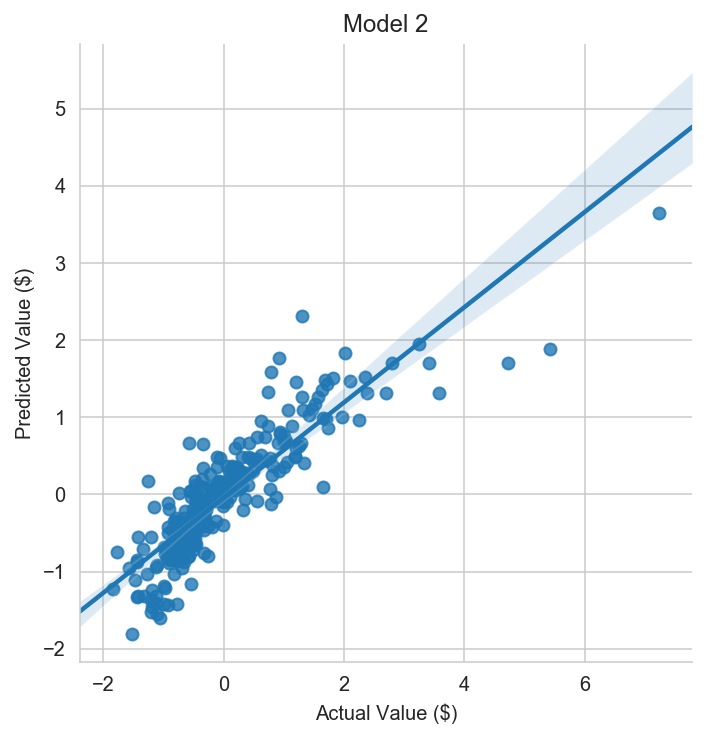

In [63]:
# create a dataframe with predicted and actual values
helper = pd.DataFrame()
helper['Actual Value ($)'] = y_com_test

# reassign the predicted value for model 2
helper['Predicted Value ($)'] = model_2.predict(X_com_test)

#create the lm plot for model 2
sns.lmplot(x='Actual Value ($)', y='Predicted Value ($)', data = helper);
ax = plt.gca()
ax.set_title("Model 2");

**Residual plots (using both training and testing data)**

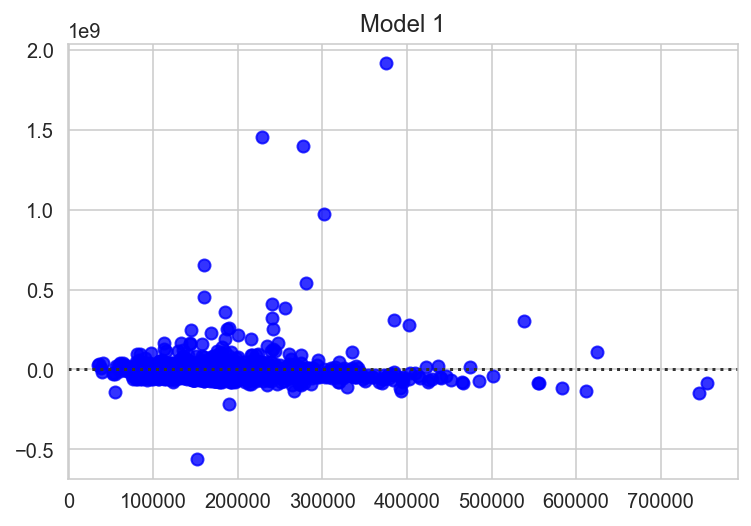

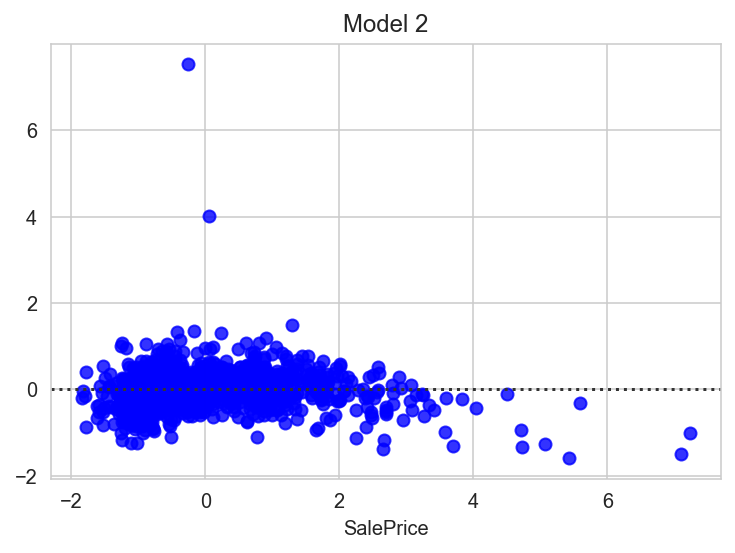

In [64]:
# create the residual plot for model 1
predictions = model.predict(X)
sns.residplot(y, predictions, color="b")
ax = plt.gca()
ax.set_title("Model 1");
plt.show()

# create the residual plot for model 2
predictions = model_2.predict(X_com)
sns.residplot(y_com, predictions, color="b")
ax = plt.gca()
ax.set_title("Model 2");

We can see that both of the models perform similarly

**Variance**

In [65]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
#calculate variance metrics for model 1
unexplained_variance = 1 - explained_variance_score(y, model.predict(X))
MAE = mean_absolute_error(y, model.predict(X))
print('Model 1')
print("Unexplained variance:", unexplained_variance)
print('Mean absolute error: '+ '$' + str(round(MAE, 2)))
print ('------------------------')

#calculate variance metrics for model 2
unexplained_variance = 1 - explained_variance_score(y_com, model_2.predict(X_com))
MAE = mean_absolute_error(y_com, model_2.predict(X_com))
print('Model 2')
print("Unexplained variance:", unexplained_variance)
print('Mean absolute error: '+ '$' + str(round(MAE, 2)))

Model 1
Unexplained variance: 1642859.0318029793
Mean absolute error: $42931488.94
------------------------
Model 2
Unexplained variance: 0.3078597120488801
Mean absolute error: $0.34


**Impotant features**

In [66]:
# arrange the lasso coefficients into a pandas dataframe
lasso_coefs = pd.DataFrame({'feature':X_com.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})
# order the dataframe by the absolute value of the coefficient
lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

# exclude coefficients that are equal to 0
strong_predictors_2 = lasso_coefs[lasso_coefs['abs_coef'] != 0].reset_index(drop=True)

#adjust the index of this d
strong_predictors_2.index = np.arange(1, len(strong_predictors_2)+1)

#add a column for the renovateable features
strong_predictors_2['renovateable'] = ['yes' if x in X_2.columns else 'no' for x in strong_predictors_2['feature']]

strong_predictors_2


feature      coef  abs_coef renovateable
1      YearBuilt  0.002572  0.002572           no
2   YearRemodAdd  0.002054  0.002054           no
3     GarageArea  0.001103  0.001103           no
4    TotalBsmtSF  0.000870  0.000870           no
5    SecondFlrSF  0.000725  0.000725           no
6     MasVnrArea  0.000507  0.000507           no
7     WoodDeckSF  0.000477  0.000477           no
8     BsmtFinSF1  0.000120  0.000120           no
9    ScreenPorch  0.000099  0.000099           no
10       LotArea  0.000006  0.000006           no
11       MiscVal -0.000005  0.000005           no